In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import cm
import cartopy.crs as ccrs
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Reshape 
from keras import initializers
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.optimizers import RMSprop
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import layers
from keras import models
from tensorflow.keras import models
import os
import scipy

Using TensorFlow backend.


In [2]:
df2 = pd.read_csv("/Volumes/SPARK/ISTI/EKF400_v1_assim_ISTI_less1831_smallest.txt", delimiter = " ")

df2

,Station ID,Var,Lon,Lat,fyr,lyr
11,USC00508503,temp2,-135.333298,57.049999,1828,1990
69,USC00226177,temp2,-91.340797,31.588900,1799,2005
125,USW00013880,temp2,-80.040298,32.898602,1823,2005
184,USW00014735,temp2,-73.809196,42.743099,1795,2005
245,IN020040900,temp2,80.182999,13.000000,1796,2005
246,IN024140300,temp2,88.333000,22.533001,1816,2005
263,RSM00022550,temp2,40.733101,64.500000,1813,2005
265,RSM00024959,temp2,129.716705,62.016701,1829,2005
273,RSM00030710,temp2,104.349998,52.266701,1820,2005
281,RSXLT181644,temp2,37.566700,55.750000,1779,2005


In [3]:
lats=df2.Lat.values
lons=df2.Lon.values

In [4]:
lats

array([57.04999924, 31.58889961, 32.89860153, 42.74309921, 13.        ,
       22.53300095, 64.5       , 62.01670074, 52.26670074, 55.75      ,
        1.29999995, 48.04999924, 50.79999924, 60.1330986 , 48.96670151,
       52.56560135, 38.11029816, 54.6330986 , 70.36699677, 63.41059875,
       55.95000076, 51.5       , 57.59999847, 50.40000153, 24.55500031])

In [5]:
lons

array([-135.33329773,  -91.34079742,  -80.04029846,  -73.80919647,
         80.18299866,   88.33300018,   40.73310089,  129.71670532,
        104.34999847,   37.56669998,  103.90000153,   14.13309956,
          4.3499999 ,   25.        ,    2.45000005,   13.31060028,
         13.35140038,   25.10000038,   31.10000038,   10.45330048,
         -3.3499999 ,    0.        ,   -3.0999999 ,   30.53310013,
        -81.75219727])

In [6]:
nlats=len(lats)
nlons=len(lons)

In [7]:
pathTo20CR = '/Volumes/SPARK/20crv3/' 
pathToMPIGE = '/Volumes/SPARK/mpi_ge/t2m/atmos/'
pathToEKF = '/Volumes/SPARK/ekf400v2/ensmean/' 
save_folder="/Volumes/SPARK/RNN_savestates/"

In [8]:
# EKF400_ensmean_v2.0_t2m_anoms_NH.nc
# air.2m.mon.mean_18512015_anoms_remap_NH.nc

In [9]:

#ds1 = xr.open_dataset(pathToERA + 'air.2m.mon.mean_18512015_anoms_rm_test2.nc')
#ds1_var=ds1.air
ds1 = xr.open_dataset(pathTo20CR  + 'air.2m.mon.mean_18512015_anoms_remap.nc')
ds1_var=ds1.air
ds2 = xr.open_dataset(pathToEKF + 'EKF400_ensmean_v2.0_t2m_anoms.nc')
ds2_var=ds2.air_temperature
ds3 = xr.open_dataset(pathTo20CR + 'prmsl.mon.mean_18512015_anoms_remap.nc')
ds3_var=ds3.prmsl
ds4 = xr.open_dataset(pathToEKF + 'EKF400_ensmean_v2.0_slp_anoms.nc')
ds4_var=ds4.air_pressure_at_sea_level



#air.2m.mon.mean_monanom.nc

In [10]:
lon_dim=ds1_var.shape[2]
lat_dim=ds1_var.shape[1]
print(lon_dim)
print(lat_dim)

192
96


In [11]:
ds1_var

<xarray.DataArray 'air' (time: 1980, lat: 96, lon: 192)>
[36495360 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2015-12-01
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 89.06 87.19 85.31 83.44 ... -85.31 -87.19 -89.06
Attributes:
    standard_name:     air_temperature
    long_name:         Monthly Air Temperature at 2 m
    units:             degK
    cell_methods:      time: mean (monthly from 3-hourly values)
    GRIB_name:         TMP
    var_desc:          Air temperature
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    level_desc:        2 m
    statistic:         Ensemble Mean
    parent_stat:       Daily Values
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [213.11884 316.28433]

In [12]:
latitudes=ds1_var.lat.values
longitudes=ds1_var.lon.values

In [13]:
resolution_lon=360/lon_dim
print(resolution_lon)
resolution_lat=180/lat_dim
print(resolution_lat)
lats=df2.Lat.values
lons=df2.Lon.values
#lons=lons+lon_dim/2
#lats=lats-lat_dim/2
lons=(lons+180)/resolution_lon
lats=(lats-90)/(resolution_lat*-1)

1.875
1.875


In [14]:
timesteps_in_data=len(ds1_var.time.values)
timesteps_in_data

1980

In [15]:
timesteps_in_testdata=len(ds2_var.time.values)
timesteps_in_testdata

4824

In [16]:
#sample_size=timesteps_in_data-1 #1300
sample_size_20cr=1979

sample_size=timesteps_in_data-1 #1300
sample_size=int(sample_size)

sample_size_half=sample_size*0.5
sample_size_half=int(sample_size_half)
sample_size_10pc=sample_size*0.1
sample_size_10pc=int(sample_size_10pc)

amount_locations=len(lats)
#amount_locations=10


amount_locations_half=amount_locations*0.5
amount_locations_half=int(amount_locations_half)
amount_locations_10pc=amount_locations*0.1
amount_locations_10pc=int(amount_locations_10pc)

amount_channels=3

#-273.15
modulator=0

In [17]:
model="20cr"
member="05"
amount_locations=amount_locations
sample_size=sample_size
resolution="lowres"
output="anoms"



RNN1_path=os.path.join(save_folder, "best_model_50p" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1_mem"+member+".h5")
RNN1lstm_path=os.path.join(save_folder, "best_model_50p" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1lstm_mem"+member+".h5")
RNN1_path_nonmax=os.path.join(save_folder, "best_model_nonmax_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1_mem"+member+".h5")
RNN1lstm_path_nonmax=os.path.join(save_folder, "best_model_nonmax_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1lstm_mem"+member+".h5")




RNN2_path=os.path.join(save_folder, "best_model_50p" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN2_mem"+member+".h5")
RNN2lstm_path=os.path.join(save_folder, "best_model_50p" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN2lstm_mem"+member+".h5")

RNN1_path_nc=os.path.join(save_folder, "best_model_ekf400_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1_mem"+member+".nc")
RNN1lstm_path_nc=os.path.join(save_folder, "best_model_ekf400_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1lstm_mem"+member+".nc")
RNN2_path_nc=os.path.join(save_folder, "best_model_ekf400_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN2_mem"+member+".nc")
RNN2lstm_path_nc=os.path.join(save_folder, "best_model_ekf400_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN2lstm_mem"+member+".nc")


RNN1_path_nc_nonmax=os.path.join(save_folder, "best_model_nonmax_ekf400_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1_mem"+member+".nc")
RNN1lstm_path_nc_nonmax=os.path.join(save_folder, "best_model_nonmax_ekf400_50p_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1lstm_mem"+member+".nc")






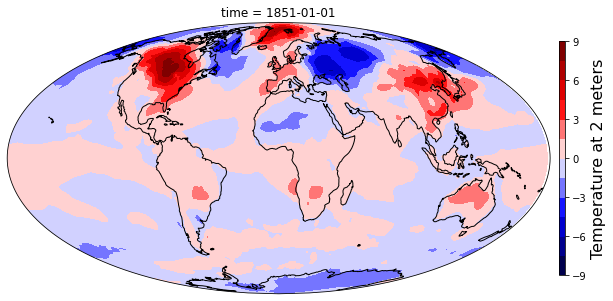

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=0, globe=None)) 
tplot=ds1_var.isel(time=0).plot.contourf(ax=ax,
levels = 17, transform=ccrs.PlateCarree(), cmap=cm.seismic, cbar_kwargs={'orientation':'vertical',
'fraction':0.012, 'pad':0.015, 'aspect':35})

tplot.colorbar.set_label('Temperature at 2 meters', size=16) 
tplot.ylabel_style = {'size':16}
ax.set_global()
ax.coastlines();

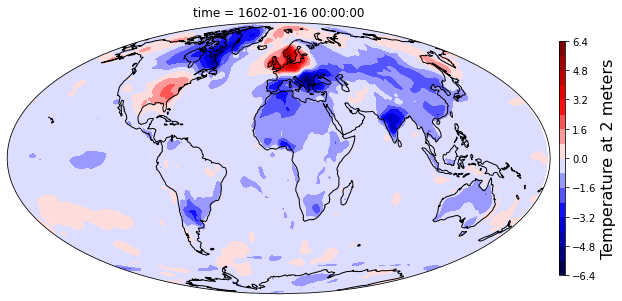

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=0, globe=None)) 
tplot=ds2_var.isel(time=0).plot.contourf(ax=ax,
levels = 17, transform=ccrs.PlateCarree(), cmap=cm.seismic, cbar_kwargs={'orientation':'vertical',
'fraction':0.012, 'pad':0.015, 'aspect':35})

tplot.colorbar.set_label('Temperature at 2 meters', size=16) 
tplot.ylabel_style = {'size':16}
ax.set_global()
ax.coastlines();

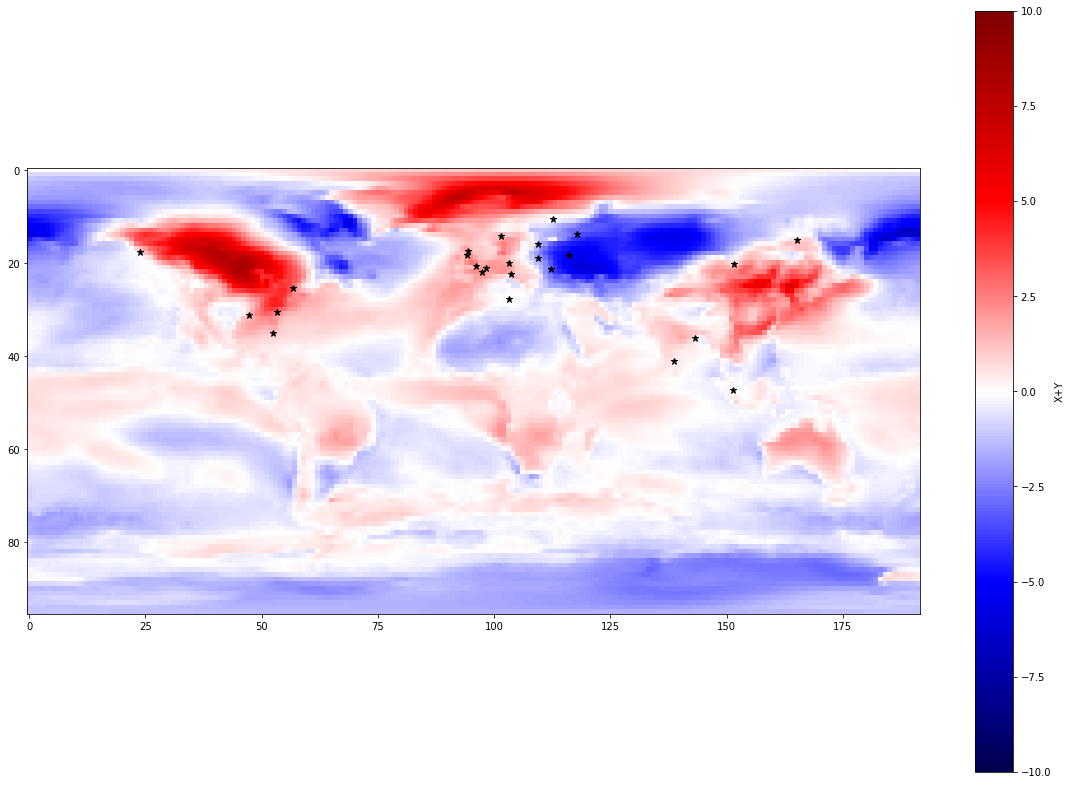

In [20]:
fig = plt.figure(figsize=(20, 14))
im=plt.imshow(ds1_var.isel(time=0), vmin=-10, vmax=10, cmap='seismic',origin='upper',interpolation="none") 
plt.plot(lons,lats,'*k', markersize=7)
cbar = plt.colorbar(im)
cbar.set_label('X+Y')

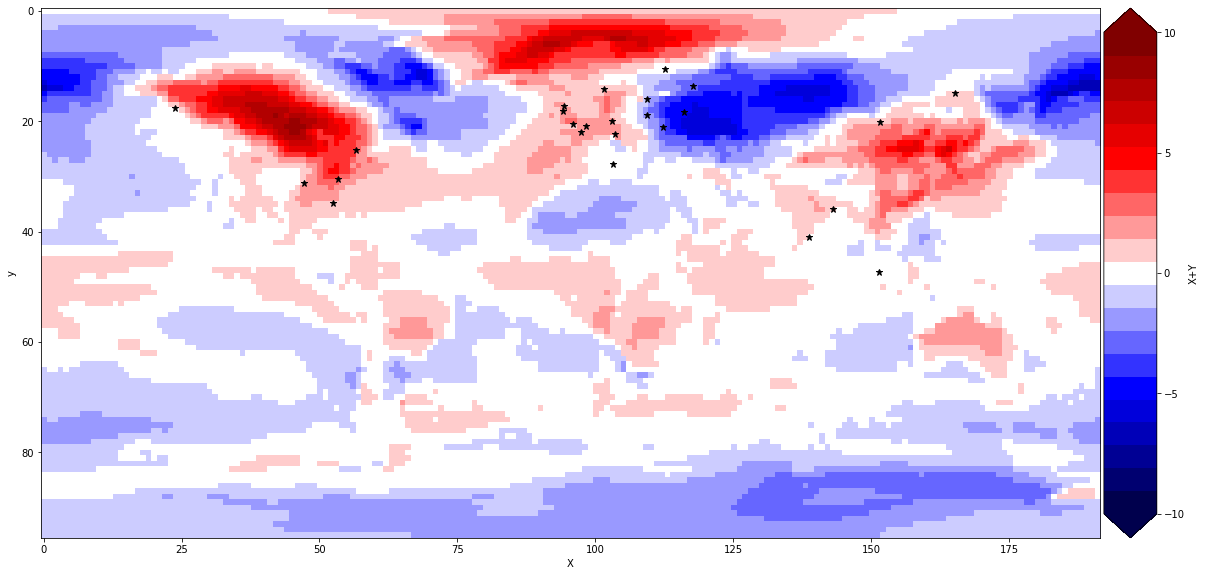

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(20, 14))


ax = plt.subplot()
im = ax.imshow(ds1_var.isel(time=0), vmin=-10, vmax=10, cmap=plt.cm.get_cmap('seismic', 21),origin='upper',interpolation="none")
plt.plot(lons,lats,'*k', markersize=7)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar=plt.colorbar(im, cax=cax,extend='both', ticks=[-10,-5,0,5,10])
cbar.set_label('X+Y')

ax.set_xlabel('X')
ax.set_ylabel('y')

plt.show()

In [22]:
ess = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
ess_nonmax = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

mc_RNN1 = ModelCheckpoint(RNN1_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
mc_RNN1lstm = ModelCheckpoint(RNN1lstm_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)


mc_RNN1_nonmax = ModelCheckpoint(RNN1_path_nonmax, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
mc_RNN1lstm_nonmax = ModelCheckpoint(RNN1lstm_path_nonmax, monitor='val_loss', mode='min', save_best_only=True, verbose=1)


mc_RNN2 = ModelCheckpoint(RNN2_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
mc_RNN2lstm = ModelCheckpoint(RNN2lstm_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)




In [23]:
N1= Sequential()
N1.add(SimpleRNN(50, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N1.add(Dense(lat_dim*lon_dim, activation='linear')) 
N1.add(Reshape((lat_dim,lon_dim)))
N1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                3800      
_________________________________________________________________
dense_1 (Dense)              (None, 18432)             940032    
_________________________________________________________________
reshape_1 (Reshape)          (None, 96, 192)           0         
Total params: 943,832
Trainable params: 943,832
Non-trainable params: 0
_________________________________________________________________


In [24]:
N1_nonmax= Sequential()
N1_nonmax.add(SimpleRNN(50, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N1_nonmax.add(Dense(lat_dim*lon_dim, activation='linear')) 
N1_nonmax.add(Reshape((lat_dim,lon_dim)))
N1_nonmax.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                3800      
_________________________________________________________________
dense_2 (Dense)              (None, 18432)             940032    
_________________________________________________________________
reshape_2 (Reshape)          (None, 96, 192)           0         
Total params: 943,832
Trainable params: 943,832
Non-trainable params: 0
_________________________________________________________________


In [25]:
N1_lstm= Sequential()
N1_lstm.add(LSTM(50, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N1_lstm.add(Dense(lat_dim*lon_dim, activation='linear')) 
N1_lstm.add(Reshape((lat_dim,lon_dim)))
N1_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                15200     
_________________________________________________________________
dense_3 (Dense)              (None, 18432)             940032    
_________________________________________________________________
reshape_3 (Reshape)          (None, 96, 192)           0         
Total params: 955,232
Trainable params: 955,232
Non-trainable params: 0
_________________________________________________________________


In [26]:
N1_lstm_nonmax= Sequential()
N1_lstm_nonmax.add(LSTM(50, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N1_lstm_nonmax.add(Dense(lat_dim*lon_dim, activation='linear')) 
N1_lstm_nonmax.add(Reshape((lat_dim,lon_dim)))
N1_lstm_nonmax.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                15200     
_________________________________________________________________
dense_4 (Dense)              (None, 18432)             940032    
_________________________________________________________________
reshape_4 (Reshape)          (None, 96, 192)           0         
Total params: 955,232
Trainable params: 955,232
Non-trainable params: 0
_________________________________________________________________


In [27]:
N2= Sequential()
N2.add(SimpleRNN(50, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N2.add(Dense(lat_dim*lon_dim, activation='relu')) 
N2.add(Reshape((lat_dim,lon_dim)))
N2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 50)                3800      
_________________________________________________________________
dense_5 (Dense)              (None, 18432)             940032    
_________________________________________________________________
reshape_5 (Reshape)          (None, 96, 192)           0         
Total params: 943,832
Trainable params: 943,832
Non-trainable params: 0
_________________________________________________________________


In [28]:
N2_lstm= Sequential()
N2_lstm.add(LSTM(50, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N2_lstm.add(Dense(lat_dim*lon_dim, activation='relu')) 
N2_lstm.add(Reshape((lat_dim,lon_dim)))
N2_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                15200     
_________________________________________________________________
dense_6 (Dense)              (None, 18432)             940032    
_________________________________________________________________
reshape_6 (Reshape)          (None, 96, 192)           0         
Total params: 955,232
Trainable params: 955,232
Non-trainable params: 0
_________________________________________________________________


In [29]:
#N1_gru= Sequential()
#N1_gru.add(GRU(300, input_shape=(amount_channels, amount_locations), activation='tanh', unroll=True))
#N1_gru.add(SimpleRNN(150))
##N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
#N1_gru.add(Dense(lat_dim*lon_dim, activation='linear')) 
#N1_gru.add(Reshape((lat_dim,lon_dim)))
#N1_gru.summary()

In [30]:
#N4= Sequential()
#N4.add(SimpleRNN(300, input_shape=(3, amount_locations), activation='tanh', unroll=True))
#N4.add(Dropout(0.4))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
#N4.add(Dense(lat_dim*lon_dim, activation='linear')) 
#N4.add(Reshape((lat_dim,lon_dim)))
#N4.summary()

In [31]:
optimizer = RMSprop(lr=0.0001, decay=1e-5) 
N1.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])
N1_lstm.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])
N1_nonmax.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])
N1_lstm_nonmax.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])
#N1_gru.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])

N2.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])
N2_lstm.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])



In [32]:
ds1_var.shape

(1980, 96, 192)

In [33]:
lon_points = np.random.randint(ds1_var.shape[2], size=(sample_size,1,amount_locations))
lon_points_test = np.random.randint(ds1_var.shape[2], size=(timesteps_in_testdata,1,amount_locations))

In [34]:
lat_points = np.random.randint(ds1_var.shape[1], size=(sample_size,1,amount_locations))
lat_points_test = np.random.randint(ds1_var.shape[1], size=(timesteps_in_testdata,1,amount_locations))


In [35]:
lon_points=lons
lat_points=lats

In [36]:
lat_points=np.array(lat_points,dtype=int)
lon_points=np.array(lon_points,dtype=int)

In [37]:
geo_locations_rand = np.random.rand(sample_size,1,nlons) # 49 for 7*7 locations
geo_locations_zero = np.zeros_like(geo_locations_rand, dtype=np.float32)

geo_locations_rand_test = np.random.rand(timesteps_in_testdata,1,nlons) # 49 for 7*7 locations
geo_locations_zero_test = np.zeros_like(geo_locations_rand_test, dtype=np.float32)

In [38]:
for i in range(0,timesteps_in_testdata):
    geo_locations_zero_test[i,0,:]=lon_points
lon_points_test=geo_locations_zero_test

In [39]:
for i in range(0,sample_size):
    geo_locations_zero[i,0,:]=lon_points
lon_points=geo_locations_zero

In [40]:
geo_locations_rand = np.random.rand(sample_size,1,nlats) # 49 for 7*7 locations
geo_locations_zero = np.zeros_like(geo_locations_rand, dtype=np.float32)

geo_locations_rand_test = np.random.rand(timesteps_in_testdata,1,nlats) # 49 for 7*7 locations
geo_locations_zero_test = np.zeros_like(geo_locations_rand_test, dtype=np.float32)

In [41]:
for i in range(0,timesteps_in_testdata):
    geo_locations_zero_test[i,0,:]=lat_points
lat_points_test=geo_locations_zero_test

In [42]:
for i in range(0,sample_size):
    geo_locations_zero[i,0,:]=lat_points
lat_points=geo_locations_zero

In [43]:
####### replace normal coordinates with snow points
#lon_points=grid_lons
#lat_points=grid_lats

In [44]:
ds1_var.shape[0]-1

1979

In [45]:
timesteps = np.random.randint(ds1_var.shape[0]-1, size=(sample_size,1,1))
timesteps_test = np.random.randint(ds2_var.shape[0], size=(timesteps_in_testdata,1,1))


In [46]:
all_timesteps_test=list(range(0,timesteps_in_testdata))
timesteps_in_testdata

4824

In [47]:
y1_array = ds1_var[timesteps.flatten(),:,:] # selecting the time steps in the grid

In [48]:
y2_array = ds2_var[timesteps_test.flatten(),:,:] # selecting the time steps in the grid

In [49]:
y2_array_nonrandom = ds2_var[all_timesteps_test,:,:] # selecting the time steps in the grid
y4_array_nonrandom = ds4_var[all_timesteps_test,:,:] # reshape to matrix, timesteps, lon*lat



In [50]:
y2_array_nonrandom.shape

(4824, 96, 192)

In [51]:
y3_array = ds3_var[timesteps.flatten(),:,:] # selecting the time steps in the grid
y4_array = ds4_var[timesteps.flatten(),:,:] # selecting the time steps in the grid

In [52]:
ds1_var.shape[2]

192

In [53]:
len(all_timesteps_test)

4824

In [54]:
y1_matrix = y1_array.values.reshape((len(timesteps),ds1_var.shape[2]*ds1_var.shape[1])) # reshape to matrix, timesteps, lon*lat
y2_matrix = y2_array_nonrandom.values.reshape((len(all_timesteps_test),ds2_var.shape[2]*ds2_var.shape[1])) # reshape to matrix, timesteps, lon*lat
y3_matrix = y3_array.values.reshape((len(timesteps),ds3_var.shape[2]*ds3_var.shape[1])) # reshape to matrix, timesteps, lon*lat
y4_matrix = y4_array_nonrandom.values.reshape((len(all_timesteps_test),ds4_var.shape[2]*ds4_var.shape[1])) # reshape to matrix, timesteps, lon*lat







In [55]:
y1_matrix.shape

(1979, 18432)

In [56]:
y2_matrix.shape

(4824, 18432)

In [57]:
y3_matrix.shape

(1979, 18432)

In [58]:
y4_matrix.shape

(4824, 18432)

In [59]:
lon_points_test.shape

(4824, 1, 25)

In [60]:
X1 = np.zeros_like(lon_points, dtype=np.float32) # create zero matrix with structure like lon_points

In [61]:
X2 = np.zeros_like(lon_points_test, dtype=np.float32) # create zero matrix with structure like lon_points

In [62]:
X3 = np.zeros_like(lon_points, dtype=np.float32) # create zero matrix with structure like lon_points

In [63]:
X4 = np.zeros_like(lon_points_test, dtype=np.float32) # create zero matrix with structure like lon_points

In [64]:
X1.shape

(1979, 1, 25)

In [65]:
X2.shape

(4824, 1, 25)

In [66]:
#for iteration in range(1):
 #   A = np.random.randint(t2m.t2m.shape[2], size=(1024,1,48))
#    B = np.random.randint(t2m.t2m.shape[1], size=(1024,1,48))
 #   t = np.random.randint(t2m.t2m.shape[0], size=(1024,1,1))
 #   C = t2m.air[t.flatten(),:,:]
 #   C1 = C.values.reshape((len(t),t2m.t2m.shape[2]*t2m.t2m.shape[1])) 
  #  C2 = np.zeros_like(A, dtype=np.float32)
  #  for i in range(len(t)): 
  #      C2[i,0,:]=C1[i,512*B[i,0,:]+A[i,0,:]]
 #   input_nn = np.concatenate((B/256,A/512,(C2-273.15+90)/(60+90)), axis=1) 
 #  N1.fit(input_nn, C-273.15, batch_size=128, epochs=100, verbose=1)

In [67]:
lon_points.shape

(1979, 1, 25)

In [68]:
lat_points.shape

(1979, 1, 25)

In [69]:
y1_matrix.shape

(1979, 18432)

In [70]:
lat_points=np.array(lat_points,dtype=int)
lon_points=np.array(lon_points,dtype=int)

lat_points_test=np.array(lat_points_test,dtype=int)
lon_points_test=np.array(lon_points_test,dtype=int)

In [71]:
lat_points

array([[[17, 31, 30, ..., 17, 21, 34]],

       [[17, 31, 30, ..., 17, 21, 34]],

       [[17, 31, 30, ..., 17, 21, 34]],

       ...,

       [[17, 31, 30, ..., 17, 21, 34]],

       [[17, 31, 30, ..., 17, 21, 34]],

       [[17, 31, 30, ..., 17, 21, 34]]])

In [72]:
for i in range(len(timesteps)): 
        X1[i,0,:]=y1_matrix[i,lat_points[i,0,:]*lon_points[i,0,:]]

In [73]:
lat_points[1,0,:]

array([17, 31, 30, 25, 41, 35, 13, 14, 20, 18, 47, 22, 20, 15, 21, 19, 27,
       18, 10, 14, 18, 20, 17, 21, 34])

In [74]:
lat_points_test[1,0,:]

array([17, 31, 30, 25, 41, 35, 13, 14, 20, 18, 47, 22, 20, 15, 21, 19, 27,
       18, 10, 14, 18, 20, 17, 21, 34])

In [75]:
for i in range(len(all_timesteps_test)): 
        X2[i,0,:]=y2_matrix[i,lat_points_test[i,0,:]*lon_points_test[i,0,:]]
#for i in range(len(timesteps_test)): 
#        X2_05[i,0,:]=y2_matrix[i,lat_points_05[i,0,:]*lon_points_05[i,0,:]]
#for i in range(len(timesteps_test)): 
#        X2_01[i,0,:]=y2_matrix[i,lat_points_01[i,0,:]*lon_points_01[i,0,:]]

In [76]:
i

4823

In [77]:
for i in range(len(timesteps)): 
        X3[i,0,:]=y3_matrix[i,lat_points[i,0,:]*lon_points[i,0,:]]

In [78]:
for i in range(len(all_timesteps_test)): 
        X4[i,0,:]=y4_matrix[i,lat_points_test[i,0,:]*lon_points_test[i,0,:]]

In [79]:
X1.shape

(1979, 1, 25)

In [80]:
lon_points_normmax=lon_points/lon_dim

lat_points_normmax=lat_points/lat_dim


In [81]:
lon_points_test_normmax=lon_points_test/lon_dim

lat_points_test_normmax=lat_points_test/lat_dim


In [82]:
X1_normmax=X1/X1.max()
X3_normmax=X3/X3.max()

In [83]:
X2_normmax=X2/X1.max()
X4_normmax=X4/X3.max()

In [84]:
#X3_normmax=X3/X3.max()
#X3_05_normmax=X3_05/X3.max()
#X3_01_normmax=X3_01/X3.max()

In [85]:
#X4_normmax=X4/X4.max()
#X4_05_normmax=X4_05/X4.max()
#X4_01_normmax=X4_01/X4.max()

In [86]:
y1_array_normmax=y1_array/y1_array.max()

y2_array_normmax=y2_array/y1_array.max()

y3_array_normmax=y3_array/y3_array.max()



y2_array_nonrandom_normax=y2_array_nonrandom/y1_array.max()

y4_array_nonrandom_normax=y4_array_nonrandom/y3_array.max()



#y3_array_normmax=y3_array/y3_array.max()

#y4_array_normmax=y4_array/y3_array.max()




In [87]:
#input_nn = np.concatenate((B/256,A/512,(C2-273.15+90)/(60+90)), axis=1) 
#N1.fit(input_nn, C-273.15, batch_size=128, epochs=100, verbose=1)

In [88]:
lat_points_normmax.shape

(1979, 1, 25)

In [89]:
lon_points_normmax.shape

(1979, 1, 25)

In [90]:
X1_normmax.shape

(1979, 1, 25)

In [91]:
input_nn = np.concatenate((lat_points_normmax,lon_points_normmax,X1_normmax),axis=1)
input_nn_slp = np.concatenate((lat_points_normmax,lon_points_normmax,X1_normmax,X3_normmax),axis=1)




In [92]:
input_nn_test = np.concatenate((lat_points_test_normmax,lon_points_test_normmax,X2_normmax),axis=1)
input_nn_test_slp = np.concatenate((lat_points_test_normmax,lon_points_test_normmax,X2_normmax,X4_normmax),axis=1)







In [93]:
input_nn.shape

(1979, 3, 25)

In [94]:
y_values=y1_array_normmax.values

In [95]:
y_values.shape

(1979, 96, 192)

In [96]:
input_nn.shape

(1979, 3, 25)

In [97]:
N1.fit(input_nn, y_values, batch_size=128, epochs=1000, verbose=1,validation_split=0.2, callbacks=[ess, mc_RNN1])

Train on 1583 samples, validate on 396 samples
Epoch 1/1000
1583/1583 [==============================] - 2s 967us/step - loss: 0.0068 - mae: 0.0550 - val_loss: 0.0065 - val_mae: 0.0534

Epoch 00001: val_loss improved from inf to 0.00649, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5


/Users/mwegmann/miniconda2/envs/weatherbench/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/1000
1583/1583 [==============================] - 1s 317us/step - loss: 0.0064 - mae: 0.0523 - val_loss: 0.0062 - val_mae: 0.0514

Epoch 00002: val_loss improved from 0.00649 to 0.00619, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 3/1000
1583/1583 [==============================] - 1s 316us/step - loss: 0.0062 - mae: 0.0509 - val_loss: 0.0060 - val_mae: 0.0504

Epoch 00003: val_loss improved from 0.00619 to 0.00602, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 4/1000
1583/1583 [==============================] - 1s 319us/step - loss: 0.0060 - mae: 0.0501 - val_loss: 0.0059 - val_mae: 0.0500

Epoch 00004: val_loss improved from 0.00602 to 0.00592, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 5/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0059 - mae: 0.0498 - val_loss: 0.

Epoch 30/1000
1583/1583 [==============================] - 1s 353us/step - loss: 0.0048 - mae: 0.0455 - val_loss: 0.0047 - val_mae: 0.0455

Epoch 00030: val_loss improved from 0.00478 to 0.00475, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 31/1000
1583/1583 [==============================] - 1s 342us/step - loss: 0.0047 - mae: 0.0453 - val_loss: 0.0047 - val_mae: 0.0454

Epoch 00031: val_loss improved from 0.00475 to 0.00472, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 32/1000
1583/1583 [==============================] - 1s 332us/step - loss: 0.0047 - mae: 0.0452 - val_loss: 0.0047 - val_mae: 0.0453

Epoch 00032: val_loss improved from 0.00472 to 0.00469, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 33/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0047 - mae: 0.0451 - val_loss

Epoch 58/1000
1583/1583 [==============================] - 1s 339us/step - loss: 0.0042 - mae: 0.0431 - val_loss: 0.0042 - val_mae: 0.0433

Epoch 00058: val_loss improved from 0.00425 to 0.00424, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 59/1000
1583/1583 [==============================] - 1s 332us/step - loss: 0.0042 - mae: 0.0430 - val_loss: 0.0042 - val_mae: 0.0433

Epoch 00059: val_loss improved from 0.00424 to 0.00422, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 60/1000
1583/1583 [==============================] - 1s 356us/step - loss: 0.0042 - mae: 0.0429 - val_loss: 0.0042 - val_mae: 0.0432

Epoch 00060: val_loss improved from 0.00422 to 0.00422, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 61/1000
1583/1583 [==============================] - 1s 342us/step - loss: 0.0041 - mae: 0.0429 - val_loss

Epoch 86/1000
1583/1583 [==============================] - 1s 349us/step - loss: 0.0039 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00086: val_loss improved from 0.00404 to 0.00403, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 87/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0039 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00087: val_loss improved from 0.00403 to 0.00403, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 88/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0039 - mae: 0.0418 - val_loss: 0.0040 - val_mae: 0.0422

Epoch 00088: val_loss improved from 0.00403 to 0.00402, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 89/1000
1583/1583 [==============================] - 1s 320us/step - loss: 0.0039 - mae: 0.0418 - val_loss

Epoch 114/1000
1583/1583 [==============================] - 1s 383us/step - loss: 0.0038 - mae: 0.0411 - val_loss: 0.0039 - val_mae: 0.0416

Epoch 00114: val_loss improved from 0.00391 to 0.00391, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 115/1000
1583/1583 [==============================] - 1s 395us/step - loss: 0.0038 - mae: 0.0411 - val_loss: 0.0039 - val_mae: 0.0415

Epoch 00115: val_loss improved from 0.00391 to 0.00390, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 116/1000
1583/1583 [==============================] - 1s 392us/step - loss: 0.0038 - mae: 0.0410 - val_loss: 0.0039 - val_mae: 0.0415

Epoch 00116: val_loss improved from 0.00390 to 0.00390, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 117/1000
1583/1583 [==============================] - 1s 381us/step - loss: 0.0038 - mae: 0.0410 - val_

Epoch 142/1000
1583/1583 [==============================] - 1s 340us/step - loss: 0.0037 - mae: 0.0405 - val_loss: 0.0038 - val_mae: 0.0410

Epoch 00142: val_loss improved from 0.00382 to 0.00381, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 143/1000
1583/1583 [==============================] - 1s 337us/step - loss: 0.0037 - mae: 0.0405 - val_loss: 0.0038 - val_mae: 0.0410

Epoch 00143: val_loss improved from 0.00381 to 0.00381, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 144/1000
1583/1583 [==============================] - 1s 360us/step - loss: 0.0037 - mae: 0.0404 - val_loss: 0.0038 - val_mae: 0.0410

Epoch 00144: val_loss improved from 0.00381 to 0.00381, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 145/1000
1583/1583 [==============================] - 1s 345us/step - loss: 0.0037 - mae: 0.0404 - val_

Epoch 170/1000
1583/1583 [==============================] - 1s 339us/step - loss: 0.0036 - mae: 0.0400 - val_loss: 0.0037 - val_mae: 0.0406

Epoch 00170: val_loss improved from 0.00375 to 0.00375, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 171/1000
1583/1583 [==============================] - 1s 318us/step - loss: 0.0036 - mae: 0.0400 - val_loss: 0.0037 - val_mae: 0.0406

Epoch 00171: val_loss improved from 0.00375 to 0.00374, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 172/1000
1583/1583 [==============================] - 1s 318us/step - loss: 0.0036 - mae: 0.0400 - val_loss: 0.0037 - val_mae: 0.0406

Epoch 00172: val_loss improved from 0.00374 to 0.00374, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 173/1000
1583/1583 [==============================] - 1s 322us/step - loss: 0.0036 - mae: 0.0400 - val_

Epoch 198/1000
1583/1583 [==============================] - 1s 340us/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0037 - val_mae: 0.0403

Epoch 00198: val_loss improved from 0.00369 to 0.00369, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 199/1000
1583/1583 [==============================] - 1s 338us/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0037 - val_mae: 0.0403

Epoch 00199: val_loss improved from 0.00369 to 0.00369, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 200/1000
1583/1583 [==============================] - 1s 341us/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0037 - val_mae: 0.0402

Epoch 00200: val_loss improved from 0.00369 to 0.00369, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 201/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0036 - mae: 0.0396 - val_

Epoch 226/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0400

Epoch 00226: val_loss improved from 0.00366 to 0.00365, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 227/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0400

Epoch 00227: val_loss improved from 0.00365 to 0.00365, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 228/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0400

Epoch 00228: val_loss improved from 0.00365 to 0.00365, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 229/1000
1583/1583 [==============================] - 1s 342us/step - loss: 0.0035 - mae: 0.0394 - val_

Epoch 255/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00255: val_loss improved from 0.00362 to 0.00362, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 256/1000
1583/1583 [==============================] - 1s 327us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00256: val_loss did not improve from 0.00362
Epoch 257/1000
1583/1583 [==============================] - 1s 338us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00257: val_loss improved from 0.00362 to 0.00362, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 258/1000
1583/1583 [==============================] - 1s 346us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00258: val_loss improved from 0.00362 to 0.00362, saving model to /

Epoch 286/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00286: val_loss improved from 0.00360 to 0.00360, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 287/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00287: val_loss improved from 0.00360 to 0.00360, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 288/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0035 - mae: 0.0389 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00288: val_loss improved from 0.00360 to 0.00360, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 289/1000
1583/1583 [==============================] - 1s 340us/step - loss: 0.0035 - mae: 0.0389 - val_

1583/1583 [==============================] - 1s 335us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00317: val_loss did not improve from 0.00358
Epoch 318/1000
1583/1583 [==============================] - 1s 346us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00318: val_loss did not improve from 0.00358
Epoch 319/1000
1583/1583 [==============================] - 1s 336us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00319: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 320/1000
1583/1583 [==============================] - 1s 336us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00320: val_loss did not improve from 0.00358
Epoch 321/1000
1583/1583 [==============================] - 1s 342us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

E

Epoch 350/1000
1583/1583 [==============================] - 1s 351us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00350: val_loss did not improve from 0.00356
Epoch 351/1000
1583/1583 [==============================] - 1s 350us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00351: val_loss improved from 0.00356 to 0.00356, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 352/1000
1583/1583 [==============================] - 1s 350us/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0036 - val_mae: 0.0394

Epoch 00352: val_loss improved from 0.00356 to 0.00356, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 353/1000
1583/1583 [==============================] - 1s 338us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00353: val_loss improved from 0.00356 to 0.00356, saving model to /

Epoch 384/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00384: val_loss improved from 0.00355 to 0.00355, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 385/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00385: val_loss did not improve from 0.00355
Epoch 386/1000
1583/1583 [==============================] - 1s 339us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00386: val_loss improved from 0.00355 to 0.00355, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 387/1000
1583/1583 [==============================] - 1s 333us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0393

Epoch 00387: val_loss improved from 0.00355 to 0.00355, saving model to /

1583/1583 [==============================] - 1s 333us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00417: val_loss did not improve from 0.00354
Epoch 418/1000
1583/1583 [==============================] - 1s 362us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00418: val_loss did not improve from 0.00354
Epoch 419/1000
1583/1583 [==============================] - 1s 344us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00419: val_loss did not improve from 0.00354
Epoch 420/1000
1583/1583 [==============================] - 1s 356us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00420: val_loss did not improve from 0.00354
Epoch 421/1000
1583/1583 [==============================] - 1s 339us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00421: val_loss improved from 0.00354 to 0.00354, saving model to /Volumes/SPARK/RNN_savestates/best

Epoch 453/1000
1583/1583 [==============================] - 1s 351us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00453: val_loss did not improve from 0.00353
Epoch 454/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00454: val_loss did not improve from 0.00353
Epoch 455/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00455: val_loss did not improve from 0.00353
Epoch 456/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00456: val_loss improved from 0.00353 to 0.00353, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 457/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val

Epoch 489/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00489: val_loss did not improve from 0.00352
Epoch 490/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00490: val_loss did not improve from 0.00352
Epoch 491/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00491: val_loss improved from 0.00352 to 0.00352, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 492/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00492: val_loss did not improve from 0.00352
Epoch 493/1000
1583/1583 [==============================] - 1s 339us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val

1583/1583 [==============================] - 1s 331us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00524: val_loss did not improve from 0.00352
Epoch 525/1000
1583/1583 [==============================] - 1s 337us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00525: val_loss improved from 0.00352 to 0.00352, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 526/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00526: val_loss did not improve from 0.00352
Epoch 527/1000
1583/1583 [==============================] - 1s 337us/step - loss: 0.0034 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00527: val_loss improved from 0.00352 to 0.00351, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 528/1000
1583/1583 [===========

1583/1583 [==============================] - 1s 328us/step - loss: 0.0034 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00561: val_loss did not improve from 0.00351
Epoch 562/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0034 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00562: val_loss did not improve from 0.00351
Epoch 563/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0034 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00563: val_loss did not improve from 0.00351
Epoch 564/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0034 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00564: val_loss did not improve from 0.00351
Epoch 565/1000
1583/1583 [==============================] - 1s 333us/step - loss: 0.0034 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00565: val_loss improved from 0.00351 to 0.00351, saving model to /Volumes/SPARK/RNN_savestates/best

1583/1583 [==============================] - 1s 341us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00598: val_loss improved from 0.00351 to 0.00350, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 599/1000
1583/1583 [==============================] - 1s 330us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00599: val_loss did not improve from 0.00350
Epoch 600/1000
1583/1583 [==============================] - 1s 340us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00600: val_loss did not improve from 0.00350
Epoch 601/1000
1583/1583 [==============================] - 1s 333us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00601: val_loss improved from 0.00350 to 0.00350, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 602/1000
1583/1583 [===========

1583/1583 [==============================] - 1s 326us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00636: val_loss improved from 0.00350 to 0.00350, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 637/1000
1583/1583 [==============================] - 1s 322us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00637: val_loss did not improve from 0.00350
Epoch 638/1000
1583/1583 [==============================] - 1s 327us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00638: val_loss did not improve from 0.00350
Epoch 639/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00639: val_loss improved from 0.00350 to 0.00350, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 640/1000
1583/1583 [===========

1583/1583 [==============================] - 1s 329us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00675: val_loss did not improve from 0.00350
Epoch 676/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00676: val_loss did not improve from 0.00350
Epoch 677/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00677: val_loss did not improve from 0.00350
Epoch 678/1000
1583/1583 [==============================] - 1s 327us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00678: val_loss did not improve from 0.00350
Epoch 679/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00679: val_loss did not improve from 0.00350
Epoch 680/1000
1583/1583 [=============================

1583/1583 [==============================] - 1s 344us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00713: val_loss did not improve from 0.00349
Epoch 714/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00714: val_loss did not improve from 0.00349
Epoch 715/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00715: val_loss did not improve from 0.00349
Epoch 716/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00716: val_loss improved from 0.00349 to 0.00349, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 717/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

E

1583/1583 [==============================] - 1s 337us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00752: val_loss did not improve from 0.00349
Epoch 753/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00753: val_loss improved from 0.00349 to 0.00349, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 754/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00754: val_loss did not improve from 0.00349
Epoch 755/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00755: val_loss did not improve from 0.00349
Epoch 756/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

E

1583/1583 [==============================] - 1s 322us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00791: val_loss did not improve from 0.00349
Epoch 792/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00792: val_loss did not improve from 0.00349
Epoch 793/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00793: val_loss improved from 0.00349 to 0.00349, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 794/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00794: val_loss did not improve from 0.00349
Epoch 795/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

E

Epoch 831/1000
1583/1583 [==============================] - 1s 323us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00831: val_loss did not improve from 0.00348
Epoch 832/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00832: val_loss did not improve from 0.00348
Epoch 833/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00833: val_loss did not improve from 0.00348
Epoch 834/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00834: val_loss did not improve from 0.00348
Epoch 835/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00835: val_loss improved from 0.00348 to 0.00348, saving model to /Volumes/SPARK/RNN_

1583/1583 [==============================] - 1s 339us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00871: val_loss did not improve from 0.00348
Epoch 872/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00872: val_loss did not improve from 0.00348
Epoch 873/1000
1583/1583 [==============================] - 1s 342us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00873: val_loss did not improve from 0.00348
Epoch 874/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00874: val_loss did not improve from 0.00348
Epoch 875/1000
1583/1583 [==============================] - 1s 333us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00875: val_loss did not improve from 0.00348
Epoch 876/1000
1583/1583 [=============================

1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00910: val_loss improved from 0.00348 to 0.00348, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 911/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00911: val_loss did not improve from 0.00348
Epoch 912/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00912: val_loss did not improve from 0.00348
Epoch 913/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00913: val_loss did not improve from 0.00348
Epoch 914/1000
1583/1583 [==============================] - 1s 323us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

E

1583/1583 [==============================] - 1s 326us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00949: val_loss did not improve from 0.00348
Epoch 950/1000
1583/1583 [==============================] - 1s 330us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00950: val_loss did not improve from 0.00348
Epoch 951/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00951: val_loss improved from 0.00348 to 0.00348, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 952/1000
1583/1583 [==============================] - 1s 335us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00952: val_loss improved from 0.00348 to 0.00348, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 953/1000
1583/1583 [===========

1583/1583 [==============================] - 1s 339us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00987: val_loss did not improve from 0.00347
Epoch 988/1000
1583/1583 [==============================] - 1s 343us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00988: val_loss did not improve from 0.00347
Epoch 989/1000
1583/1583 [==============================] - 1s 336us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00989: val_loss did not improve from 0.00347
Epoch 990/1000
1583/1583 [==============================] - 1s 336us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00990: val_loss did not improve from 0.00347
Epoch 991/1000
1583/1583 [==============================] - 1s 334us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00991: val_loss did not improve from 0.00347
Epoch 992/1000
1583/1583 [=============================

In [98]:
N1_nonmax.fit(input_nn, y_values, batch_size=128, epochs=1000, verbose=1,validation_split=0.2, callbacks=[ess_nonmax, mc_RNN1_nonmax])

Train on 1583 samples, validate on 396 samples
Epoch 1/1000
1583/1583 [==============================] - 1s 874us/step - loss: 0.0068 - mae: 0.0548 - val_loss: 0.0065 - val_mae: 0.0532

Epoch 00001: val_loss improved from inf to 0.00647, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 2/1000
 384/1583 [======>.......................] - ETA: 0s - loss: 0.0066 - mae: 0.0532

/Users/mwegmann/miniconda2/envs/weatherbench/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


1583/1583 [==============================] - 0s 296us/step - loss: 0.0064 - mae: 0.0523 - val_loss: 0.0062 - val_mae: 0.0514

Epoch 00002: val_loss improved from 0.00647 to 0.00619, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 3/1000
1583/1583 [==============================] - 0s 309us/step - loss: 0.0062 - mae: 0.0509 - val_loss: 0.0060 - val_mae: 0.0505

Epoch 00003: val_loss improved from 0.00619 to 0.00603, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 4/1000
1583/1583 [==============================] - 1s 322us/step - loss: 0.0060 - mae: 0.0502 - val_loss: 0.0059 - val_mae: 0.0500

Epoch 00004: val_loss improved from 0.00603 to 0.00593, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 5/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0060 - mae: 0.0498 - v

1583/1583 [==============================] - 1s 330us/step - loss: 0.0048 - mae: 0.0456 - val_loss: 0.0048 - val_mae: 0.0456

Epoch 00029: val_loss improved from 0.00480 to 0.00476, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 30/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0047 - mae: 0.0455 - val_loss: 0.0047 - val_mae: 0.0455

Epoch 00030: val_loss improved from 0.00476 to 0.00473, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 31/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0047 - mae: 0.0453 - val_loss: 0.0047 - val_mae: 0.0454

Epoch 00031: val_loss improved from 0.00473 to 0.00470, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 32/1000
1583/1583 [==============================] - 1s 323us/step - loss: 0.0047 - mae: 0.0452 

Epoch 56/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0042 - mae: 0.0432 - val_loss: 0.0042 - val_mae: 0.0434

Epoch 00056: val_loss improved from 0.00425 to 0.00424, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 57/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0042 - mae: 0.0431 - val_loss: 0.0042 - val_mae: 0.0434

Epoch 00057: val_loss improved from 0.00424 to 0.00423, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 58/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0042 - mae: 0.0430 - val_loss: 0.0042 - val_mae: 0.0433

Epoch 00058: val_loss improved from 0.00423 to 0.00422, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 59/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0042 

Epoch 83/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0040 - mae: 0.0420 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00083: val_loss improved from 0.00404 to 0.00403, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 84/1000
1583/1583 [==============================] - 1s 316us/step - loss: 0.0040 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00084: val_loss improved from 0.00403 to 0.00403, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 85/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0039 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00085: val_loss improved from 0.00403 to 0.00402, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 86/1000
1583/1583 [==============================] - 1s 323us/step - loss: 0.0039 

Epoch 110/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0038 - mae: 0.0412 - val_loss: 0.0039 - val_mae: 0.0416

Epoch 00110: val_loss improved from 0.00391 to 0.00391, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 111/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0038 - mae: 0.0412 - val_loss: 0.0039 - val_mae: 0.0416

Epoch 00111: val_loss improved from 0.00391 to 0.00390, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 112/1000
1583/1583 [==============================] - 1s 317us/step - loss: 0.0038 - mae: 0.0411 - val_loss: 0.0039 - val_mae: 0.0415

Epoch 00112: val_loss improved from 0.00390 to 0.00390, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 113/1000
1583/1583 [==============================] - 1s 317us/step - loss: 0.0

Epoch 137/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0037 - mae: 0.0405 - val_loss: 0.0038 - val_mae: 0.0410

Epoch 00137: val_loss improved from 0.00382 to 0.00382, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 138/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0037 - mae: 0.0405 - val_loss: 0.0038 - val_mae: 0.0410

Epoch 00138: val_loss improved from 0.00382 to 0.00381, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 139/1000
1583/1583 [==============================] - 1s 323us/step - loss: 0.0037 - mae: 0.0405 - val_loss: 0.0038 - val_mae: 0.0410

Epoch 00139: val_loss improved from 0.00381 to 0.00381, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 140/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0

Epoch 164/1000
1583/1583 [==============================] - 1s 330us/step - loss: 0.0036 - mae: 0.0401 - val_loss: 0.0037 - val_mae: 0.0406

Epoch 00164: val_loss improved from 0.00375 to 0.00375, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 165/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0036 - mae: 0.0401 - val_loss: 0.0037 - val_mae: 0.0406

Epoch 00165: val_loss improved from 0.00375 to 0.00374, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 166/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0036 - mae: 0.0401 - val_loss: 0.0037 - val_mae: 0.0406

Epoch 00166: val_loss improved from 0.00374 to 0.00374, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 167/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0

1583/1583 [==============================] - 1s 317us/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0037 - val_mae: 0.0403

Epoch 00191: val_loss improved from 0.00370 to 0.00370, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 192/1000
1583/1583 [==============================] - 0s 314us/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0037 - val_mae: 0.0403

Epoch 00192: val_loss improved from 0.00370 to 0.00369, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 193/1000
1583/1583 [==============================] - 0s 314us/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0037 - val_mae: 0.0402

Epoch 00193: val_loss improved from 0.00369 to 0.00369, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 194/1000
1583/1583 [==============================] - 1s 323us/step - loss: 0.0036 - mae: 0.03

1583/1583 [==============================] - 1s 328us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0400

Epoch 00218: val_loss improved from 0.00366 to 0.00366, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 219/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0400

Epoch 00219: val_loss did not improve from 0.00366
Epoch 220/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0400

Epoch 00220: val_loss improved from 0.00366 to 0.00366, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 221/1000
1583/1583 [==============================] - 1s 327us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0037 - val_mae: 0.0401

Epoch 00221: val_loss did not improve from 0.00366
Epoch 222/1000
1583/1


Epoch 00246: val_loss improved from 0.00363 to 0.00363, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 247/1000
1583/1583 [==============================] - 1s 325us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00247: val_loss improved from 0.00363 to 0.00363, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 248/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00248: val_loss did not improve from 0.00363
Epoch 249/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00249: val_loss improved from 0.00363 to 0.00362, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 250/1000
1583/1583 [=======

Epoch 277/1000
1583/1583 [==============================] - 1s 326us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00277: val_loss did not improve from 0.00360
Epoch 278/1000
1583/1583 [==============================] - 1s 328us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00278: val_loss improved from 0.00360 to 0.00360, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 279/1000
1583/1583 [==============================] - 1s 327us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00279: val_loss improved from 0.00360 to 0.00360, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 280/1000
1583/1583 [==============================] - 1s 347us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00280: val_loss improved from 0.00360 to 0.00360, s


Epoch 00306: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 307/1000
1583/1583 [==============================] - 1s 329us/step - loss: 0.0035 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00307: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 308/1000
1583/1583 [==============================] - 1s 324us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00308: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1_mem05.h5
Epoch 309/1000
1583/1583 [==============================] - 0s 314us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00309: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPA

In [99]:
N1_lstm.fit(input_nn, y_values, batch_size=128, epochs=1000, verbose=1,validation_split=0.2, callbacks=[ess, mc_RNN1lstm])

Train on 1583 samples, validate on 396 samples
Epoch 1/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 0.0063 - mae: 0.0508 - val_loss: 0.0062 - val_mae: 0.0508

Epoch 00001: val_loss improved from inf to 0.00624, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 2/1000
 384/1583 [======>.......................] - ETA: 0s - loss: 0.0063 - mae: 0.0508

/Users/mwegmann/miniconda2/envs/weatherbench/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


1583/1583 [==============================] - 1s 328us/step - loss: 0.0063 - mae: 0.0507 - val_loss: 0.0062 - val_mae: 0.0507

Epoch 00002: val_loss improved from 0.00624 to 0.00621, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 3/1000
1583/1583 [==============================] - 1s 349us/step - loss: 0.0063 - mae: 0.0505 - val_loss: 0.0062 - val_mae: 0.0505

Epoch 00003: val_loss improved from 0.00621 to 0.00618, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 4/1000
1583/1583 [==============================] - 1s 371us/step - loss: 0.0062 - mae: 0.0503 - val_loss: 0.0061 - val_mae: 0.0503

Epoch 00004: val_loss improved from 0.00618 to 0.00615, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 5/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0062 - mae: 0.0502 - val_loss: 0.0


Epoch 00029: val_loss improved from 0.00577 to 0.00576, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 30/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0058 - mae: 0.0494 - val_loss: 0.0057 - val_mae: 0.0494

Epoch 00030: val_loss improved from 0.00576 to 0.00574, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 31/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0058 - mae: 0.0493 - val_loss: 0.0057 - val_mae: 0.0493

Epoch 00031: val_loss improved from 0.00574 to 0.00573, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 32/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0058 - mae: 0.0493 - val_loss: 0.0057 - val_mae: 0.0493

Epoch 00032: val_loss improved from 0.00573 to 0.00572, saving model to /Volumes/SPARK/RNN_savestat

Epoch 57/1000
1583/1583 [==============================] - 1s 364us/step - loss: 0.0049 - mae: 0.0462 - val_loss: 0.0049 - val_mae: 0.0462

Epoch 00057: val_loss improved from 0.00494 to 0.00490, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 58/1000
1583/1583 [==============================] - 1s 365us/step - loss: 0.0049 - mae: 0.0460 - val_loss: 0.0049 - val_mae: 0.0460

Epoch 00058: val_loss improved from 0.00490 to 0.00487, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 59/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0049 - mae: 0.0459 - val_loss: 0.0048 - val_mae: 0.0459

Epoch 00059: val_loss improved from 0.00487 to 0.00483, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 60/1000
1583/1583 [==============================] - 1s 372us/step - loss: 0.0048 - mae: 0.045

1583/1583 [==============================] - 1s 377us/step - loss: 0.0044 - mae: 0.0440 - val_loss: 0.0044 - val_mae: 0.0442

Epoch 00084: val_loss improved from 0.00441 to 0.00440, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 85/1000
1583/1583 [==============================] - 1s 368us/step - loss: 0.0044 - mae: 0.0440 - val_loss: 0.0044 - val_mae: 0.0442

Epoch 00085: val_loss improved from 0.00440 to 0.00439, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 86/1000
1583/1583 [==============================] - 1s 362us/step - loss: 0.0043 - mae: 0.0439 - val_loss: 0.0044 - val_mae: 0.0441

Epoch 00086: val_loss improved from 0.00439 to 0.00438, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 87/1000
1583/1583 [==============================] - 1s 367us/step - loss: 0.0043 - mae: 0.0439 - val_loss: 

1583/1583 [==============================] - 1s 377us/step - loss: 0.0041 - mae: 0.0429 - val_loss: 0.0042 - val_mae: 0.0433

Epoch 00111: val_loss improved from 0.00420 to 0.00419, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 112/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0041 - mae: 0.0429 - val_loss: 0.0042 - val_mae: 0.0432

Epoch 00112: val_loss improved from 0.00419 to 0.00419, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 113/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0041 - mae: 0.0429 - val_loss: 0.0042 - val_mae: 0.0432

Epoch 00113: val_loss improved from 0.00419 to 0.00418, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 114/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0041 - mae: 0.0428 - val_los

1583/1583 [==============================] - 1s 369us/step - loss: 0.0040 - mae: 0.0421 - val_loss: 0.0040 - val_mae: 0.0425

Epoch 00138: val_loss improved from 0.00405 to 0.00405, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 139/1000
1583/1583 [==============================] - 1s 374us/step - loss: 0.0040 - mae: 0.0421 - val_loss: 0.0040 - val_mae: 0.0424

Epoch 00139: val_loss improved from 0.00405 to 0.00404, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 140/1000
1583/1583 [==============================] - 1s 372us/step - loss: 0.0040 - mae: 0.0420 - val_loss: 0.0040 - val_mae: 0.0424

Epoch 00140: val_loss improved from 0.00404 to 0.00404, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 141/1000
1583/1583 [==============================] - 1s 372us/step - loss: 0.0040 - mae: 0.0420 - val_los

1583/1583 [==============================] - 1s 364us/step - loss: 0.0038 - mae: 0.0414 - val_loss: 0.0039 - val_mae: 0.0418

Epoch 00165: val_loss improved from 0.00393 to 0.00393, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 166/1000
1583/1583 [==============================] - 1s 371us/step - loss: 0.0038 - mae: 0.0413 - val_loss: 0.0039 - val_mae: 0.0418

Epoch 00166: val_loss improved from 0.00393 to 0.00393, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 167/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0038 - mae: 0.0413 - val_loss: 0.0039 - val_mae: 0.0417

Epoch 00167: val_loss improved from 0.00393 to 0.00392, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 168/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0038 - mae: 0.0413 - val_los

1583/1583 [==============================] - 1s 365us/step - loss: 0.0037 - mae: 0.0407 - val_loss: 0.0038 - val_mae: 0.0413

Epoch 00192: val_loss improved from 0.00384 to 0.00384, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 193/1000
1583/1583 [==============================] - 1s 374us/step - loss: 0.0037 - mae: 0.0408 - val_loss: 0.0038 - val_mae: 0.0412

Epoch 00193: val_loss improved from 0.00384 to 0.00384, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 194/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0037 - mae: 0.0407 - val_loss: 0.0038 - val_mae: 0.0412

Epoch 00194: val_loss improved from 0.00384 to 0.00383, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 195/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0037 - mae: 0.0407 - val_los

1583/1583 [==============================] - 1s 375us/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0038 - val_mae: 0.0408

Epoch 00219: val_loss improved from 0.00377 to 0.00377, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 220/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0038 - val_mae: 0.0408

Epoch 00220: val_loss improved from 0.00377 to 0.00377, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 221/1000
1583/1583 [==============================] - 1s 387us/step - loss: 0.0037 - mae: 0.0402 - val_loss: 0.0038 - val_mae: 0.0408

Epoch 00221: val_loss improved from 0.00377 to 0.00376, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 222/1000
1583/1583 [==============================] - 1s 363us/step - loss: 0.0037 - mae: 0.0402 - val_los

Epoch 247/1000
1583/1583 [==============================] - 1s 371us/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0037 - val_mae: 0.0404

Epoch 00247: val_loss improved from 0.00372 to 0.00371, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 248/1000
1583/1583 [==============================] - 1s 368us/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0037 - val_mae: 0.0404

Epoch 00248: val_loss improved from 0.00371 to 0.00371, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 249/1000
1583/1583 [==============================] - 1s 368us/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0037 - val_mae: 0.0404

Epoch 00249: val_loss improved from 0.00371 to 0.00371, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 250/1000
1583/1583 [==============================] - 1s 372us/step - loss: 0.0036 - mae: 0

Epoch 277/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0036 - mae: 0.0396 - val_loss: 0.0037 - val_mae: 0.0402

Epoch 00277: val_loss improved from 0.00367 to 0.00367, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 278/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0036 - mae: 0.0396 - val_loss: 0.0037 - val_mae: 0.0402

Epoch 00278: val_loss improved from 0.00367 to 0.00367, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 279/1000
1583/1583 [==============================] - 1s 364us/step - loss: 0.0036 - mae: 0.0396 - val_loss: 0.0037 - val_mae: 0.0402

Epoch 00279: val_loss did not improve from 0.00367
Epoch 280/1000
1583/1583 [==============================] - 1s 438us/step - loss: 0.0036 - mae: 0.0396 - val_loss: 0.0037 - val_mae: 0.0401

Epoch 00280: val_loss did not improve from 0.00367
Epoch 281/1000

Epoch 309/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0036 - val_mae: 0.0399

Epoch 00309: val_loss did not improve from 0.00364
Epoch 310/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0035 - mae: 0.0393 - val_loss: 0.0036 - val_mae: 0.0400

Epoch 00310: val_loss improved from 0.00364 to 0.00364, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 311/1000
1583/1583 [==============================] - 1s 374us/step - loss: 0.0035 - mae: 0.0394 - val_loss: 0.0036 - val_mae: 0.0400

Epoch 00311: val_loss improved from 0.00364 to 0.00364, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 312/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0035 - mae: 0.0393 - val_loss: 0.0036 - val_mae: 0.0399

Epoch 00312: val_loss did not improve from 0.00364
Epoch 313/1000

1583/1583 [==============================] - 1s 377us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00341: val_loss improved from 0.00362 to 0.00362, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 342/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00342: val_loss improved from 0.00362 to 0.00362, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 343/1000
1583/1583 [==============================] - 1s 365us/step - loss: 0.0035 - mae: 0.0392 - val_loss: 0.0036 - val_mae: 0.0398

Epoch 00343: val_loss improved from 0.00362 to 0.00361, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 344/1000
1583/1583 [==============================] - 1s 364us/step - loss: 0.0035 - mae: 0.0391 - val_los

1583/1583 [==============================] - 1s 374us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0397

Epoch 00372: val_loss did not improve from 0.00360
Epoch 373/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0397

Epoch 00373: val_loss improved from 0.00360 to 0.00359, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 374/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0397

Epoch 00374: val_loss did not improve from 0.00359
Epoch 375/1000
1583/1583 [==============================] - 1s 363us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.0397

Epoch 00375: val_loss did not improve from 0.00359
Epoch 376/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0036 - val_mae: 0.039

1583/1583 [==============================] - 1s 389us/step - loss: 0.0034 - mae: 0.0389 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00407: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 408/1000
1583/1583 [==============================] - 1s 370us/step - loss: 0.0034 - mae: 0.0389 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00408: val_loss did not improve from 0.00358
Epoch 409/1000
1583/1583 [==============================] - 1s 397us/step - loss: 0.0034 - mae: 0.0389 - val_loss: 0.0036 - val_mae: 0.0396

Epoch 00409: val_loss improved from 0.00358 to 0.00358, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 410/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0034 - mae: 0.0388 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00410: val_loss did not improve from 0.00358
Epoch 411/1000
1583/1583 [===

Epoch 441/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0395

Epoch 00441: val_loss did not improve from 0.00356
Epoch 442/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0394

Epoch 00442: val_loss improved from 0.00356 to 0.00356, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 443/1000
1583/1583 [==============================] - 1s 383us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0394

Epoch 00443: val_loss did not improve from 0.00356
Epoch 444/1000
1583/1583 [==============================] - 1s 392us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0394

Epoch 00444: val_loss did not improve from 0.00356
Epoch 445/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0036 -

Epoch 476/1000
1583/1583 [==============================] - 1s 385us/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00476: val_loss did not improve from 0.00355
Epoch 477/1000
1583/1583 [==============================] - 1s 392us/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00477: val_loss improved from 0.00355 to 0.00355, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 478/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00478: val_loss improved from 0.00355 to 0.00355, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 479/1000
1583/1583 [==============================] - 1s 362us/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0036 - val_mae: 0.0393

Epoch 00479: val_loss improved from 0.00355 to 0.00355, saving mo

Epoch 512/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0393

Epoch 00512: val_loss did not improve from 0.00354
Epoch 513/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0393

Epoch 00513: val_loss did not improve from 0.00354
Epoch 514/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0393

Epoch 00514: val_loss improved from 0.00354 to 0.00354, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 515/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0034 - mae: 0.0385 - val_loss: 0.0035 - val_mae: 0.0393

Epoch 00515: val_loss improved from 0.00354 to 0.00354, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 516/1000

1583/1583 [==============================] - 1s 392us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00549: val_loss improved from 0.00353 to 0.00353, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 550/1000
1583/1583 [==============================] - 1s 389us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00550: val_loss did not improve from 0.00353
Epoch 551/1000
1583/1583 [==============================] - 1s 387us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00551: val_loss improved from 0.00353 to 0.00353, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 552/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0392

Epoch 00552: val_loss did not improve from 0.00353
Epoch 553/1000
1583/1583 [===

1583/1583 [==============================] - 1s 407us/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00586: val_loss did not improve from 0.00352
Epoch 587/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00587: val_loss did not improve from 0.00352
Epoch 588/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00588: val_loss improved from 0.00352 to 0.00352, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 589/1000
1583/1583 [==============================] - 1s 368us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00589: val_loss did not improve from 0.00352
Epoch 590/1000
1583/1583 [==============================] - 1s 367us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.039

Epoch 625/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00625: val_loss did not improve from 0.00351
Epoch 626/1000
1583/1583 [==============================] - 1s 387us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00626: val_loss did not improve from 0.00351
Epoch 627/1000
1583/1583 [==============================] - 1s 381us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00627: val_loss improved from 0.00351 to 0.00351, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 628/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0035 - val_mae: 0.0391

Epoch 00628: val_loss improved from 0.00351 to 0.00351, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 629/1000

1583/1583 [==============================] - 1s 394us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00661: val_loss improved from 0.00351 to 0.00351, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 662/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00662: val_loss did not improve from 0.00351
Epoch 663/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00663: val_loss did not improve from 0.00351
Epoch 664/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00664: val_loss did not improve from 0.00351
Epoch 665/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.039

1583/1583 [==============================] - 1s 378us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00699: val_loss did not improve from 0.00350
Epoch 700/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00700: val_loss improved from 0.00350 to 0.00350, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 701/1000
1583/1583 [==============================] - 1s 371us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00701: val_loss improved from 0.00350 to 0.00350, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 702/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0390

Epoch 00702: val_loss did not improve from 0.00350
Epoch 703/1000
1583/1583 [===

1583/1583 [==============================] - 1s 389us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00736: val_loss improved from 0.00350 to 0.00349, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 737/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00737: val_loss did not improve from 0.00349
Epoch 738/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00738: val_loss did not improve from 0.00349
Epoch 739/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00739: val_loss did not improve from 0.00349
Epoch 740/1000
1583/1583 [==============================] - 1s 381us/step - loss: 0.0033 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.038


Epoch 00772: val_loss did not improve from 0.00349
Epoch 773/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00773: val_loss did not improve from 0.00349
Epoch 774/1000
1583/1583 [==============================] - 1s 384us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00774: val_loss improved from 0.00349 to 0.00349, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 775/1000
1583/1583 [==============================] - 1s 390us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00775: val_loss improved from 0.00349 to 0.00349, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 776/1000
1583/1583 [==============================] - 1s 381us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00776: 

1583/1583 [==============================] - 1s 385us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00808: val_loss did not improve from 0.00348
Epoch 809/1000
1583/1583 [==============================] - 1s 394us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00809: val_loss did not improve from 0.00348
Epoch 810/1000
1583/1583 [==============================] - 1s 390us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00810: val_loss did not improve from 0.00348
Epoch 811/1000
1583/1583 [==============================] - 1s 387us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0389

Epoch 00811: val_loss did not improve from 0.00348
Epoch 812/1000
1583/1583 [==============================] - 1s 389us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00812: val_loss did not improve from 0.00348
Epoch 813/1000
1583/1583 [=============================

1583/1583 [==============================] - 1s 374us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00847: val_loss did not improve from 0.00348
Epoch 848/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00848: val_loss did not improve from 0.00348
Epoch 849/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00849: val_loss did not improve from 0.00348
Epoch 850/1000
1583/1583 [==============================] - 1s 381us/step - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00850: val_loss improved from 0.00348 to 0.00348, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 851/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.038

1583/1583 [==============================] - 1s 376us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00887: val_loss improved from 0.00348 to 0.00348, saving model to /Volumes/SPARK/RNN_savestates/best_model_50panoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 888/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00888: val_loss did not improve from 0.00348
Epoch 889/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00889: val_loss did not improve from 0.00348
Epoch 890/1000
1583/1583 [==============================] - 1s 374us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00890: val_loss did not improve from 0.00348
Epoch 891/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.038

1583/1583 [==============================] - 1s 378us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00926: val_loss did not improve from 0.00347
Epoch 927/1000
1583/1583 [==============================] - 1s 373us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00927: val_loss did not improve from 0.00347
Epoch 928/1000
1583/1583 [==============================] - 1s 383us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00928: val_loss did not improve from 0.00347
Epoch 929/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00929: val_loss did not improve from 0.00347
Epoch 930/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0035 - val_mae: 0.0388

Epoch 00930: val_loss did not improve from 0.00347
Epoch 931/1000
1583/1583 [=============================

1583/1583 [==============================] - 1s 376us/step - loss: 0.0033 - mae: 0.0378 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00967: val_loss did not improve from 0.00347
Epoch 968/1000
1583/1583 [==============================] - 1s 388us/step - loss: 0.0033 - mae: 0.0378 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00968: val_loss did not improve from 0.00347
Epoch 969/1000
1583/1583 [==============================] - 1s 390us/step - loss: 0.0033 - mae: 0.0378 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00969: val_loss did not improve from 0.00347
Epoch 970/1000
1583/1583 [==============================] - 1s 387us/step - loss: 0.0033 - mae: 0.0378 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00970: val_loss did not improve from 0.00347
Epoch 971/1000
1583/1583 [==============================] - 1s 385us/step - loss: 0.0033 - mae: 0.0378 - val_loss: 0.0035 - val_mae: 0.0387

Epoch 00971: val_loss did not improve from 0.00347
Epoch 972/1000
1583/1583 [=============================

In [100]:
N1_lstm_nonmax.fit(input_nn, y_values, batch_size=128, epochs=1000, verbose=1,validation_split=0.2, callbacks=[ess_nonmax, mc_RNN1lstm_nonmax])

Train on 1583 samples, validate on 396 samples
Epoch 1/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 0.0063 - mae: 0.0509 - val_loss: 0.0062 - val_mae: 0.0508

Epoch 00001: val_loss improved from inf to 0.00624, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5


/Users/mwegmann/miniconda2/envs/weatherbench/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/1000
1583/1583 [==============================] - 1s 331us/step - loss: 0.0063 - mae: 0.0507 - val_loss: 0.0062 - val_mae: 0.0507

Epoch 00002: val_loss improved from 0.00624 to 0.00621, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 3/1000
1583/1583 [==============================] - 1s 338us/step - loss: 0.0063 - mae: 0.0505 - val_loss: 0.0062 - val_mae: 0.0505

Epoch 00003: val_loss improved from 0.00621 to 0.00617, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 4/1000
1583/1583 [==============================] - 1s 330us/step - loss: 0.0062 - mae: 0.0503 - val_loss: 0.0061 - val_mae: 0.0503

Epoch 00004: val_loss improved from 0.00617 to 0.00614, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 5/1000
1583/1583 [==============================] - 1s 351us/step - loss:

Epoch 29/1000
1583/1583 [==============================] - 1s 370us/step - loss: 0.0058 - mae: 0.0494 - val_loss: 0.0058 - val_mae: 0.0495

Epoch 00029: val_loss improved from 0.00578 to 0.00577, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 30/1000
1583/1583 [==============================] - 1s 364us/step - loss: 0.0058 - mae: 0.0494 - val_loss: 0.0058 - val_mae: 0.0494

Epoch 00030: val_loss improved from 0.00577 to 0.00576, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 31/1000
1583/1583 [==============================] - 1s 367us/step - loss: 0.0058 - mae: 0.0494 - val_loss: 0.0057 - val_mae: 0.0494

Epoch 00031: val_loss improved from 0.00576 to 0.00575, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 32/1000
1583/1583 [==============================] - 1s 387us/step - l

Epoch 56/1000
1583/1583 [==============================] - 1s 372us/step - loss: 0.0050 - mae: 0.0463 - val_loss: 0.0050 - val_mae: 0.0464

Epoch 00056: val_loss improved from 0.00500 to 0.00496, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 57/1000
1583/1583 [==============================] - 1s 378us/step - loss: 0.0049 - mae: 0.0462 - val_loss: 0.0049 - val_mae: 0.0462

Epoch 00057: val_loss improved from 0.00496 to 0.00491, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 58/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0049 - mae: 0.0460 - val_loss: 0.0049 - val_mae: 0.0460

Epoch 00058: val_loss improved from 0.00491 to 0.00487, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 59/1000
1583/1583 [==============================] - 1s 376us/step - l

Epoch 83/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0044 - mae: 0.0440 - val_loss: 0.0044 - val_mae: 0.0442

Epoch 00083: val_loss improved from 0.00441 to 0.00440, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 84/1000
1583/1583 [==============================] - 1s 382us/step - loss: 0.0043 - mae: 0.0439 - val_loss: 0.0044 - val_mae: 0.0441

Epoch 00084: val_loss improved from 0.00440 to 0.00439, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 85/1000
1583/1583 [==============================] - 1s 379us/step - loss: 0.0043 - mae: 0.0439 - val_loss: 0.0044 - val_mae: 0.0441

Epoch 00085: val_loss improved from 0.00439 to 0.00438, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 86/1000
1583/1583 [==============================] - 1s 380us/step - l

Epoch 110/1000
1583/1583 [==============================] - 1s 376us/step - loss: 0.0041 - mae: 0.0428 - val_loss: 0.0042 - val_mae: 0.0432

Epoch 00110: val_loss improved from 0.00419 to 0.00418, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 111/1000
1583/1583 [==============================] - 1s 365us/step - loss: 0.0041 - mae: 0.0428 - val_loss: 0.0042 - val_mae: 0.0431

Epoch 00111: val_loss improved from 0.00418 to 0.00417, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 112/1000
1583/1583 [==============================] - 1s 357us/step - loss: 0.0041 - mae: 0.0427 - val_loss: 0.0042 - val_mae: 0.0431

Epoch 00112: val_loss improved from 0.00417 to 0.00417, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 113/1000
1583/1583 [==============================] - 1s 364us/step

Epoch 137/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0039 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00137: val_loss improved from 0.00403 to 0.00402, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 138/1000
1583/1583 [==============================] - 1s 361us/step - loss: 0.0039 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00138: val_loss improved from 0.00402 to 0.00402, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 139/1000
1583/1583 [==============================] - 1s 360us/step - loss: 0.0039 - mae: 0.0419 - val_loss: 0.0040 - val_mae: 0.0423

Epoch 00139: val_loss improved from 0.00402 to 0.00401, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 140/1000
1583/1583 [==============================] - 1s 371us/step

Epoch 164/1000
1583/1583 [==============================] - 1s 365us/step - loss: 0.0038 - mae: 0.0412 - val_loss: 0.0039 - val_mae: 0.0417

Epoch 00164: val_loss improved from 0.00392 to 0.00391, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 165/1000
1583/1583 [==============================] - 1s 368us/step - loss: 0.0038 - mae: 0.0412 - val_loss: 0.0039 - val_mae: 0.0417

Epoch 00165: val_loss improved from 0.00391 to 0.00391, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 166/1000
1583/1583 [==============================] - 1s 386us/step - loss: 0.0038 - mae: 0.0412 - val_loss: 0.0039 - val_mae: 0.0417

Epoch 00166: val_loss improved from 0.00391 to 0.00391, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 167/1000
1583/1583 [==============================] - 1s 376us/step

1583/1583 [==============================] - 1s 372us/step - loss: 0.0037 - mae: 0.0407 - val_loss: 0.0038 - val_mae: 0.0411

Epoch 00191: val_loss improved from 0.00384 to 0.00383, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 192/1000
1583/1583 [==============================] - 1s 380us/step - loss: 0.0037 - mae: 0.0407 - val_loss: 0.0038 - val_mae: 0.0411

Epoch 00192: val_loss improved from 0.00383 to 0.00383, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 193/1000
1583/1583 [==============================] - 1s 371us/step - loss: 0.0037 - mae: 0.0406 - val_loss: 0.0038 - val_mae: 0.0411

Epoch 00193: val_loss improved from 0.00383 to 0.00382, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 194/1000
1583/1583 [==============================] - 1s 381us/step - loss: 0.0037

Epoch 218/1000
1583/1583 [==============================] - 1s 362us/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0038 - val_mae: 0.0408

Epoch 00218: val_loss improved from 0.00377 to 0.00376, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 219/1000
1583/1583 [==============================] - 1s 367us/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0038 - val_mae: 0.0408

Epoch 00219: val_loss improved from 0.00376 to 0.00376, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 220/1000
1583/1583 [==============================] - 1s 366us/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0038 - val_mae: 0.0407

Epoch 00220: val_loss improved from 0.00376 to 0.00376, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 221/1000
1583/1583 [==============================] - 1s 378us/step

Epoch 246/1000
1583/1583 [==============================] - 1s 377us/step - loss: 0.0036 - mae: 0.0400 - val_loss: 0.0037 - val_mae: 0.0404

Epoch 00246: val_loss improved from 0.00372 to 0.00371, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 247/1000
1583/1583 [==============================] - 1s 384us/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0037 - val_mae: 0.0405

Epoch 00247: val_loss improved from 0.00371 to 0.00371, saving model to /Volumes/SPARK/RNN_savestates/best_model_nonmax_50p_anoms_20cr_lowres_25_1979_RNN1lstm_mem05.h5
Epoch 248/1000
1583/1583 [==============================] - 1s 383us/step - loss: 0.0036 - mae: 0.0400 - val_loss: 0.0037 - val_mae: 0.0404

Epoch 00248: val_loss did not improve from 0.00371
Epoch 249/1000
1583/1583 [==============================] - 1s 375us/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0037 - val_mae: 0.0405

Epoch 00249: val_loss did not improve from 0.0037

In [101]:
Est_RNN1= N1.predict(input_nn)
Est_RNN1_test= N1.predict(input_nn_test)
Est_RNN1_test_lstm=N1_lstm.predict(input_nn_test)

Est_RNN1_test_nonmax= N1_nonmax.predict(input_nn_test)
Est_RNN1_test_lstm_nonmax=N1_lstm_nonmax.predict(input_nn_test)



#Est_RNN2= N2.predict(input_nn)
#Est_RNN2_test= N2.predict(input_nn_test)
#Est_RNN2_test_lstm= N2_lstm.predict(input_nn_test)




#Est3= N3.predict(input_nn)
#Est4= N4.predict(input_nn)

In [102]:
Est_RNN1.shape

(1979, 96, 192)

In [103]:
half_data=sample_size/2
half_data=int(half_data)

In [104]:
unnormalize=y1_array.max().values

original_values=y1_array_normmax[half_data,:,:]*y1_array.max()+modulator

max=np.nanmax(original_values)
min=np.nanmin(original_values)

minmax=[min,max]
square=np.square(minmax)
root=np.sqrt(square)
round=np.round(root)
max=np.nanmax(round)
max=np.round(max,1)




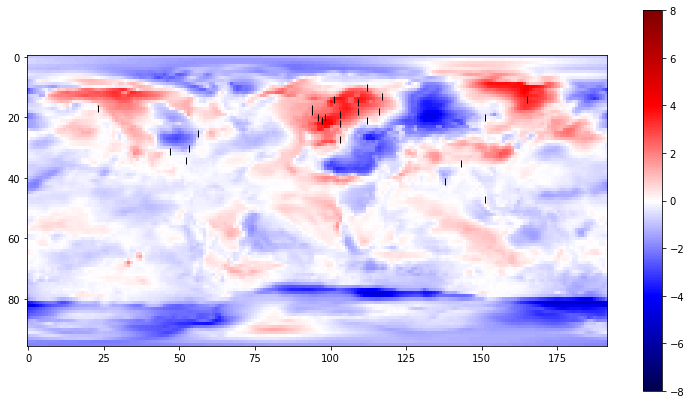

In [105]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(y1_array_normmax[0,:,:]*y1_array.max()+modulator, vmin=-max, vmax=max, cmap='seismic',origin='upper',interpolation="none") 
plt.plot(input_nn[half_data,1,:]*lon_dim,input_nn[half_data,0,:]*lat_dim,'|k', markersize=7)
plt.colorbar()

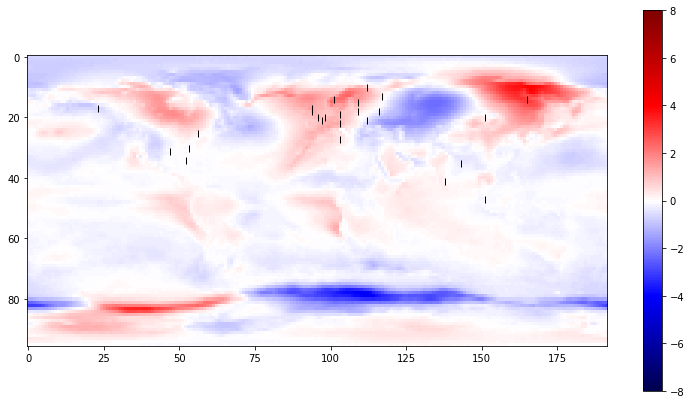

In [106]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(Est_RNN1[0,:,:]*unnormalize+modulator, vmin=-max, vmax=max, cmap='seismic',origin='upper',interpolation="none") 
plt.plot(input_nn[half_data,1,:]*lon_dim,input_nn[half_data,0,:]*lat_dim,'|k', markersize=7)
plt.colorbar()

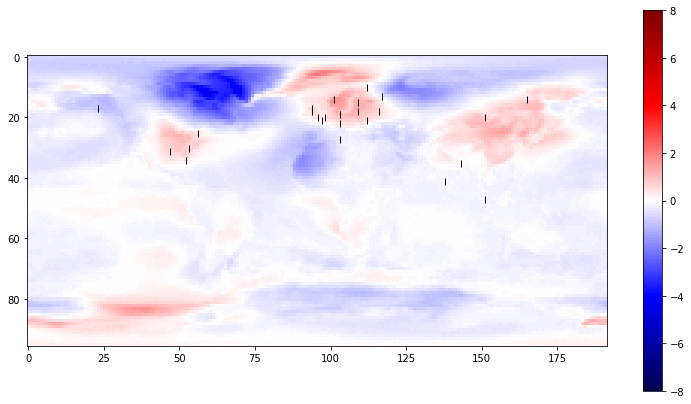

In [107]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(Est_RNN1_test[0,:,:]*unnormalize+modulator, vmin=-max, vmax=max, cmap='seismic',origin='upper',interpolation="none") 
plt.plot(input_nn[half_data,1,:]*lon_dim,input_nn[half_data,0,:]*lat_dim,'|k', markersize=7)
plt.colorbar()

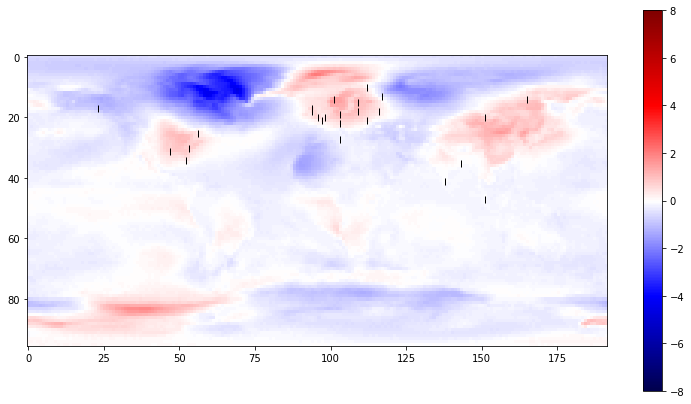

In [108]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(Est_RNN1_test_lstm[0,:,:]*unnormalize+modulator, vmin=-max, vmax=max, cmap='seismic',origin='upper',interpolation="none") 
plt.plot(input_nn[half_data,1,:]*lon_dim,input_nn[half_data,0,:]*lat_dim,'|k', markersize=7)
plt.colorbar()

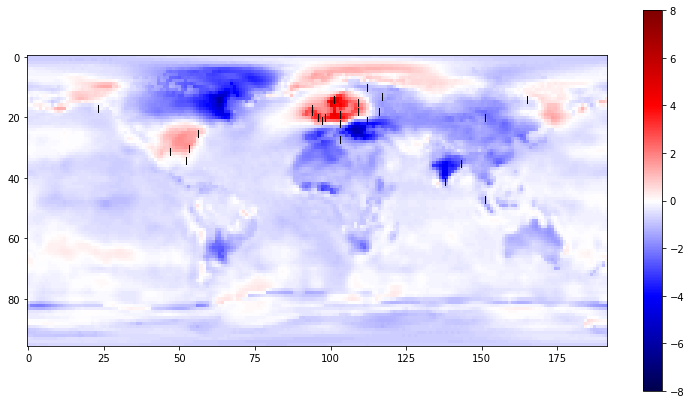

In [109]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(y2_array_nonrandom_normax[0,:,:]*y1_array.max()+modulator, vmin=-max, vmax=max, cmap='seismic',origin='upper',interpolation="none") 
plt.plot(input_nn[:,1,:]*lon_dim,input_nn[:,0,:]*lat_dim,'|k', markersize=7)
plt.colorbar()

In [110]:
#!/usr/bin/env ipython
# ---------------------
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num
# -----------------------
nyears = Est_RNN1_test.shape[0];
output=RNN1_path_nc
unout = 'days since 1900-01-01 00:00:00'
# -----------------------
ny, nx = (lat_dim, lon_dim)
lon = longitudes
lat = latitudes

dataout = Est_RNN1_test[:,:,:]*unnormalize; # create some random data
datesout = [datetime.datetime(1900+iyear,1,1) for iyear in range(nyears)]; # create datevalues
# =========================
ncout = Dataset(output,'w','NETCDF4'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nyears);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable("t2m",'float32',('time','lat','lon'));myvar.setncattr('units',"K");myvar[:] = dataout;
ncout.close();

In [111]:
#!/usr/bin/env ipython
# ---------------------
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num
# -----------------------
nyears = Est_RNN1_test_nonmax.shape[0];
output=RNN1_path_nc_nonmax
unout = 'days since 1900-01-01 00:00:00'
# -----------------------
ny, nx = (lat_dim, lon_dim)
lon = longitudes
lat = latitudes

dataout = Est_RNN1_test_nonmax[:,:,:]*unnormalize; # create some random data
datesout = [datetime.datetime(1900+iyear,1,1) for iyear in range(nyears)]; # create datevalues
# =========================
ncout = Dataset(output,'w','NETCDF4'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nyears);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable("t2m",'float32',('time','lat','lon'));myvar.setncattr('units',"K");myvar[:] = dataout;
ncout.close();

In [112]:
#!/usr/bin/env ipython
# ---------------------
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num
# -----------------------
nyears = Est_RNN1_test_lstm.shape[0];
output=RNN1lstm_path_nc
unout = 'days since 1900-01-01 00:00:00'
# -----------------------
ny, nx = (lat_dim, lon_dim)
lon = longitudes
lat = latitudes

dataout = Est_RNN1_test_lstm[:,:,:]*unnormalize; # create some random data
datesout = [datetime.datetime(1900+iyear,1,1) for iyear in range(nyears)]; # create datevalues
# =========================
ncout = Dataset(output,'w','NETCDF4'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nyears);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable("t2m",'float32',('time','lat','lon'));myvar.setncattr('units',"K");myvar[:] = dataout;
ncout.close();

In [113]:
#!/usr/bin/env ipython
# ---------------------
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num
# -----------------------
nyears = Est_RNN1_test_lstm.shape[0];
output=RNN1lstm_path_nc_nonmax
unout = 'days since 1900-01-01 00:00:00'
# -----------------------
ny, nx = (lat_dim, lon_dim)
lon = longitudes
lat = latitudes

dataout = Est_RNN1_test_lstm_nonmax[:,:,:]*unnormalize; # create some random data
datesout = [datetime.datetime(1900+iyear,1,1) for iyear in range(nyears)]; # create datevalues
# =========================
ncout = Dataset(output,'w','NETCDF4'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nyears);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable("t2m",'float32',('time','lat','lon'));myvar.setncattr('units',"K");myvar[:] = dataout;
ncout.close();

In [114]:
rmse_matrix = np.zeros_like(Est_RNN1[half_data,:,:], dtype=np.float32) # create zero matrix with structure like A
rmse_matrix2 = np.zeros_like(Est_RNN1_test[0,:,:], dtype=np.float32) # create zero matrix with structure like A

In [115]:
y1_array_normmax_4_corr=y1_array_normmax.values.reshape((len(timesteps),ds1_var.shape[2]*ds1_var.shape[1]))
y1_array_normmax_4_corr.shape

(1979, 18432)

In [116]:
y2_array_normmax_4_corr=y2_array_normmax.values.reshape((len(timesteps_test-1),ds2_var.shape[2]*ds2_var.shape[1]))
y2_array_normmax_4_corr.shape

(4824, 18432)

In [117]:
y2_array_nonrandom_normax_4_corr=y2_array_nonrandom_normax.values.reshape((len(timesteps_test),ds2_var.shape[2]*ds2_var.shape[1]))
y2_array_nonrandom_normax_4_corr.shape

(4824, 18432)

In [118]:
Est_RNN1.shape

(1979, 96, 192)

In [119]:
len(timesteps)

1979

In [120]:
Est_RNN1_4_corr=Est_RNN1.reshape((len(timesteps),ds1_var.shape[2]*ds1_var.shape[1]))
Est_RNN1_test_4_corr=Est_RNN1_test.reshape((len(timesteps_test-1),ds1_var.shape[2]*ds1_var.shape[1]))
Est_RNN1_test_lstm_4_corr=Est_RNN1_test_lstm.reshape((len(timesteps_test-1),ds1_var.shape[2]*ds1_var.shape[1]))


In [121]:
structure_dummy= np.arange(y1_array_normmax_4_corr.shape[1], dtype=float)
structure_dummy.shape

(18432,)

In [122]:
for a in range(1,y1_array_normmax_4_corr.shape[1]):
    one_R=np.corrcoef(Est_RNN1_4_corr[:,a], y1_array_normmax_4_corr[:,a])
    structure_dummy[a]=one_R[0,1]
corr_matrix_Est_RNN1=structure_dummy.reshape(ds1_var.shape[1],ds1_var.shape[2])

In [123]:
structure_dummy= np.arange(y1_array_normmax_4_corr.shape[0], dtype=float)
structure_dummy.shape
for a in range(1,y1_array_normmax_4_corr.shape[0]):
    one_R=np.corrcoef(Est_RNN1_4_corr[a,:], y1_array_normmax_4_corr[a,:])
    structure_dummy[a]=one_R[0,1]
corr_vector_Est_RNN1=structure_dummy

In [124]:
structure_dummy= np.arange(y2_array_normmax_4_corr.shape[1], dtype=float)
structure_dummy.shape

(18432,)

In [125]:
for a in range(1,y2_array_nonrandom_normax_4_corr.shape[1]):
    one_R=np.corrcoef(Est_RNN1_test_4_corr[:,a], y2_array_nonrandom_normax_4_corr[:,a])
    structure_dummy[a]=one_R[0,1]
corr_matrix_Est_RNN1_test=structure_dummy.reshape(ds2_var.shape[1],ds2_var.shape[2])

In [126]:
structure_dummy= np.arange(y2_array_nonrandom_normax_4_corr.shape[0], dtype=float)
structure_dummy.shape
for a in range(1,y2_array_nonrandom_normax_4_corr.shape[0]):
    one_R=np.corrcoef(Est_RNN1_test_4_corr[a,:], y2_array_nonrandom_normax_4_corr[a,:])
    structure_dummy[a]=one_R[0,1]
corr_vector_Est_RNN1_test=structure_dummy

In [127]:
structure_dummy= np.arange(y2_array_nonrandom_normax_4_corr.shape[1], dtype=float)
structure_dummy.shape

(18432,)

In [128]:
for a in range(1,y2_array_nonrandom_normax_4_corr.shape[1]):
    one_R=np.corrcoef(Est_RNN1_test_lstm_4_corr[:,a], y2_array_nonrandom_normax_4_corr[:,a])
    structure_dummy[a]=one_R[0,1]
corr_matrix_Est_RNN1_test_lstm=structure_dummy.reshape(ds2_var.shape[1],ds2_var.shape[2])

In [129]:
structure_dummy= np.arange(y2_array_nonrandom_normax_4_corr.shape[0], dtype=float)
structure_dummy.shape
for a in range(1,y2_array_nonrandom_normax_4_corr.shape[0]):
    one_R=np.corrcoef(Est_RNN1_test_lstm_4_corr[a,:], y2_array_nonrandom_normax_4_corr[a,:])
    structure_dummy[a]=one_R[0,1]
corr_vector_Est_RNN1_test_lstm=structure_dummy

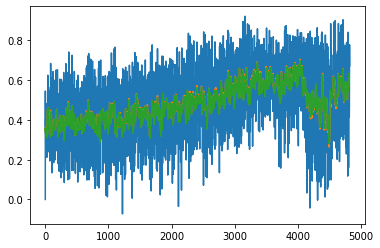

In [130]:
corr_vector_Est_RNN1_test_lstm_rm12=np.cumsum(corr_vector_Est_RNN1_test_lstm, axis = 0)
corr_vector_Est_RNN1_test_lstm_rm12=corr_vector_Est_RNN1_test_lstm_rm12/12
corr_vector_Est_RNN1_test_lstm_rm12[12:] -= corr_vector_Est_RNN1_test_lstm_rm12[:-12]
corr_vector_Est_RNN1_test_lstm_rm12=corr_vector_Est_RNN1_test_lstm_rm12[11:]
#
corr_vector_Est_RNN1_test_rm12=np.cumsum(corr_vector_Est_RNN1_test, axis = 0)
corr_vector_Est_RNN1_test_rm12=corr_vector_Est_RNN1_test_rm12/12
corr_vector_Est_RNN1_test_rm12[12:] -= corr_vector_Est_RNN1_test_rm12[:-12]
corr_vector_Est_RNN1_test_rm12=corr_vector_Est_RNN1_test_rm12[11:]
#
plt.plot(corr_vector_Est_RNN1_test_lstm)
plt.plot(corr_vector_Est_RNN1_test_lstm_rm12)
plt.plot(corr_vector_Est_RNN1_test_rm12)


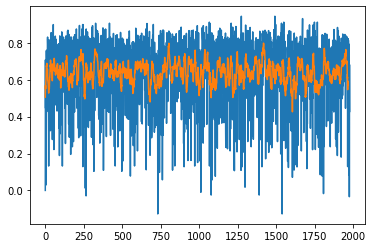

In [131]:
corr_vector_Est_RNN1_rm12=np.cumsum(corr_vector_Est_RNN1, axis = 0)
corr_vector_Est_RNN1_rm12=corr_vector_Est_RNN1_rm12/12
corr_vector_Est_RNN1_rm12[12:] -= corr_vector_Est_RNN1_rm12[:-12]
corr_vector_Est_RNN1_rm12=corr_vector_Est_RNN1_rm12[11:]
plt.plot(corr_vector_Est_RNN1)
plt.plot(corr_vector_Est_RNN1_rm12)

In [132]:
# all of field data
corr_matrix_Est_RNN1.mean()

0.4949236761200845

In [133]:
corr_matrix_Est_RNN1_test.mean()

0.4525534047846685

In [134]:
corr_matrix_Est_RNN1_test_lstm.mean()

0.4564811836611343

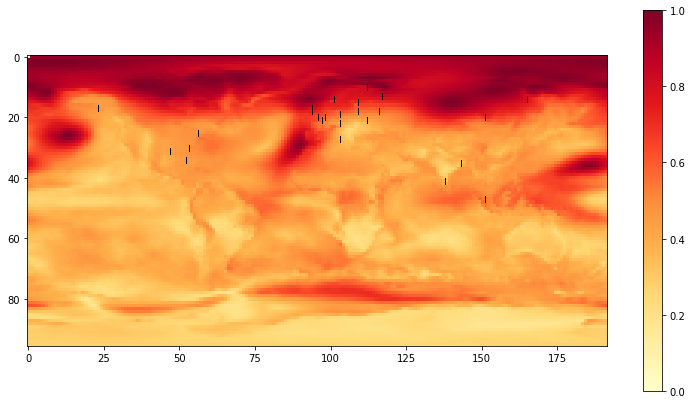

In [135]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(corr_matrix_Est_RNN1, vmin=0, vmax=1, cmap='YlOrRd',origin='upper',interpolation="none") 
plt.plot(input_nn[:,1,:]*lon_dim,input_nn[:,0,:]*lat_dim,'|k')
plt.colorbar()

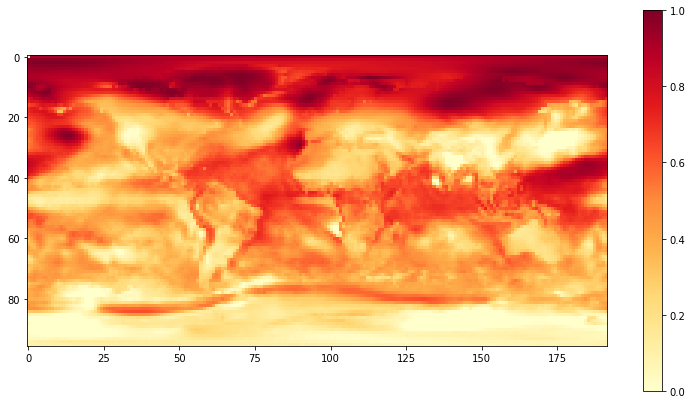

In [136]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(corr_matrix_Est_RNN1_test, vmin=0, vmax=1, cmap='YlOrRd',origin='upper',interpolation="none") 
plt.colorbar()

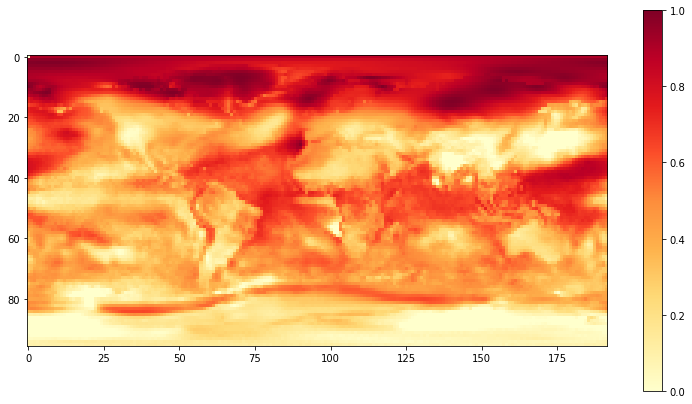

In [137]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(corr_matrix_Est_RNN1_test_lstm, vmin=0, vmax=1, cmap='YlOrRd',origin='upper',interpolation="none") 
plt.colorbar()

In [138]:
rmse_matrix_Est_RNN1 = np.zeros_like(Est_RNN1[0,:,:], dtype=np.float32) # create zero matrix with structure like 
rmse_matrix_Est_RNN1_test = np.zeros_like(Est_RNN1_test[0,:,:], dtype=np.float32) # create zero matrix with structure like 
rmse_matrix_Est_RNN1_test_lstm = np.zeros_like(Est_RNN1_test_lstm[0,:,:], dtype=np.float32) # create zero matrix with structure like 

In [139]:
from sklearn.metrics import mean_squared_error

for a in range(1,lon_dim):
    print(a)
    for b in range(1,lat_dim):
        y_pred=Est_RNN1_test[:,b,a]*unnormalize+modulator
        y_true=y2_array_nonrandom_normax[:,b,a]*y1_array.max()+modulator
        rmse_matrix_Est_RNN1_test[b,a]=mean_squared_error(y_true, y_pred, squared=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [140]:
rmse_matrix.shape

(96, 192)

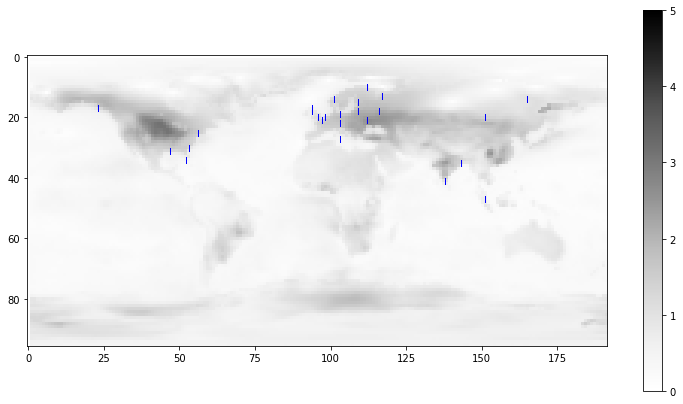

In [141]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(rmse_matrix_Est_RNN1_test, vmin=0, vmax=5, cmap='Greys',origin='upper',interpolation="none") 
plt.plot(input_nn[:,1,:]*lon_dim,input_nn[:,0,:]*lat_dim,'|b')
plt.colorbar()

In [142]:
# all of field data
rmse_matrix_Est_RNN1_test.mean()

0.5803635

In [ ]:
from sklearn.metrics import mean_squared_error

for a in range(1,lon_dim):
    print(a)
    for b in range(1,lat_dim):
        y_pred=Est_RNN1_test_lstm[:,b,a]*unnormalize+modulator
        y_true=y2_array_nonrandom_normax[:,b,a]*y1_array.max()+modulator
        rmse_matrix_Est_RNN1_test_lstm[b,a]=mean_squared_error(y_true, y_pred, squared=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


In [ ]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(rmse_matrix_Est_RNN1_test_lstm, vmin=0, vmax=5, cmap='Greys',origin='upper',interpolation="none") 
plt.plot(input_nn[:,1,:]*lon_dim,input_nn[:,0,:]*lat_dim,'|b')
plt.colorbar()

In [ ]:
rmse_matrix_Est_RNN1_test_lstm.mean()